In [1]:
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


import time as t

In [2]:
import pandas as pd
import sys
import pybullet as p
from env_pybullet_gen3 import env_pybullet_kin_gen3



In [3]:
#To improve the velocity, run it on the GPU


#Create a experiment env
env = env_pybullet_kin_gen3(no_zeros = True,Excels_path_Okay_tcp_list = ["Tcp_Trajectori_19_2.xlsx","Tcp_Trajectori_39_2.xlsx","Tcp_Trajectori_59_2.xlsx"],time_step=0.02,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
env.robot.visual_inspection = False

#Initially parameters of the urdf

#Make maxvels closer to the reality
#both have to be modified
env.max_vel = [168,151,128,94,210,48,189]
env.original_parameters_df ["max_vel"]=env.max_vel
print(env.original_parameters_df["max_vel"])
print(env.original_parameters_df)


print('observation space:', env.observation_space) #states, There is only 1 state constant
env.update_parameters_to_modify(["mass","max_vel","kp","ki","kd","force_x_one","Ixx","Iyy","Izz"])
print('action space:', env.action_space) #parameters, number of parameters choose to tune, continuous
print('original action:', env.action_original()) #parameters, number of parameters choose to tune, continuous




hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
Base parameters mod    mass_base  Ixx_base  Iyy_base  Izz_base
0   1.697353  0.005787  0.005796  0.002735
Base parameters     mass_base  Ixx_base  Iyy_base  Izz_base
0   1.697353  0.005787  0.005796  0.002735
0    168
1    151
2    128
3     94
4    210
5     48
6    189
Name: max_vel, dtype: int64
       mass damping       Ixx       Iyy       Izz   kp   ki   kd  max_vel  \
0  1.377353       0  0.004801  0.004755  0.002283  0.1  0.0  0.0      168   
1  1.163667       0  0.008419  0.001920  0.008361  0.1  0.0  0.0      151   
2  1.163660       0  0.007545  0.007487  0.001921  0.1  0.0  0.0      128   
3  0.930287       0  0.006410  0.001380  0.006518  0.1  0.0  0.0       94   
4  0.678106       0  0.001680  0.001506  0.000826  0.1  0.0  0.0      210   
5  0.678106       0  0.001938  0.000827  0.001763  0.1  0.0  0.0       48   
6  0.500657       0  0.000775  0.000585  0.000975  0.1  0.0  0.0 

In [4]:
#Cross Entrophy Method, to choose the weights

# In my case where only 1 action,and that it's apply the parameters do another step doesn't change anything due to the state doesn't vary
# For this reason max_t and gama doesn't make sense, so I set them to max_t = 1 and gamma to 0
def cem_no_net(n_iterations=700, max_t=1, gamma=0.0, print_every=50, pop_size=env.action_space, elite_frac=10/(env.action_space*2), sigma=0.3,sigma_reduction_every_print = 0.65, per_one = True ):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
        per_one (boolean): to determine if the output is in per one or not
    """
    #Numbers of elements that you keep as the better ones
    n_elite=int(pop_size*elite_frac)
    
    #scores doble end queee , from iterations size * 0.1
    scores_deque = deque(maxlen=int(n_iterations*0.1))
    #intial scores empty
    scores = []
    #Save actions to see how they evolve
    best_actions = []
    #Select a seed to make the results the same every test, not depending on the seed
    np.random.seed(0)
    #Initial best weights, are from 0 to 1, it's good to be small the weights, but they should be different from 0.
    # small to avoid overfiting , different from 0 to update them
    
    if (per_one == True):
        best_weight = sigma*np.random.randn(env.action_space)
        original_action = np.array(env.action_original())
    else:
        best_weight = np.add(sigma*np.random.randn(env.action_space),env.action_original())

    #Each iteration, modify  + (from 0 to 1) the best weight randomly
    #Computes the reward with these weights
    #Sort the reward to get the best ones
    # Save the best weights
    # the Best weight it's the mean of the best one
    #compute the main reward of the main best rewards ones
    #this it's show to evalute how good its
    
    for i_iteration in range(1, n_iterations+1):
        
        #Generate new population weights, as a mutation of the best weight to test them
        weights_pop = [best_weight + (sigma*np.random.randn(env.action_space)) for i in range(pop_size)]
        
        #Compute the parameters and obtain the rewards for each of them
        #print("iteration "+str(i_iteration))
        if (per_one == True):
            rewards=[]
            for weights in weights_pop:
                #print("New weights")
                #print(weights)
                #t.sleep(1000)
                action=np.add(np.multiply(weights,original_action),original_action)
                rewards.append( env.step_tcp_rishabh_joints_offset(action) )
            rewards = np.array(rewards)
        else:
            rewards=[]
            for weights in weights_pop:
                rewards.append(env.step_tcp_rishabh_joints_offset(weights) )
            rewards = np.array(rewards)
        print("rewards" + str(i_iteration))
        print(rewards)
        #print("\n")
        
        #Sort the rewards to obtain the best ones
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        
        #Set the best weight as the mean of the best ones 
       
        best_weight = np.array(elite_weights).mean(axis=0)
        
        #Get the reward with this new weight
        
        if (per_one == True):
            action = np.add(np.multiply(best_weight,original_action),original_action)
            #print("action vel")
            #print(action[8])
            #print("action kp")
            #print(action[15])
            #time.sleep(1000)
            best_actions.append(action)
            reward = env.step_tcp_rishabh_joints_offset(action)
            print("reward")
            print(reward)
            print("\n")
        else:
            best_actions.append(best_weight)
            reward = env.step_tcp_rishabh_joints_offset(best_weight)
        scores_deque.append(reward)
        scores.append(reward)
        
        #save the check point
        env.save_parameters("./Parameters_train_tcp_euc_rishabh_joint_offset.xlsx")
        
        if i_iteration % print_every == 0:
            sigma = sigma * sigma_reduction_every_print
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=0.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-n_iterations*0.1, np.mean(scores_deque)))
            break
    return scores,best_actions


rewards1
[-0.31865777 -0.32715082 -0.31921778 -0.29689059 -0.29987244 -0.37693843
 -0.33045168 -0.29565887 -0.30760239 -0.3330075  -0.36106787 -0.32378141
 -0.31884275 -0.33255375 -0.32033693 -0.35532928 -0.35056459 -0.34282334
 -0.36459123 -0.30669276 -0.31337572 -0.30634272 -0.33575848 -0.32286736
 -0.29175672 -0.3090194  -0.36471141 -0.34480999 -0.32477081 -0.38009352
 -0.32132319 -0.29131141 -0.35496344 -0.34303688 -0.32111895 -0.32027903
 -0.31380586 -0.31608278 -0.29001454 -0.31436843 -0.32626693 -0.32104667
 -0.35114189 -0.3171779  -0.32663662 -0.36006939 -0.31271248 -0.30238731
 -0.33774128 -0.31087739 -0.31316849 -0.31102192 -0.32789855 -0.33361849
 -0.32817083 -0.38030667 -0.32987404 -0.31215711 -0.4300915  -0.32916245
 -0.34864437 -0.33284773 -0.34536761]
reward
-0.2903485716253356


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations 

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards8
[-0.20845755 -0.18455536 -0.21197984 -0.20320251 -0.19315545 -0.19567784
 -0.19221875 -0.36632862 -0.17309895 -0.19198236 -0.18829629 -0.17740349
 -0.21881874 -0.32560884 -0.21694614 -0.17989927 -0.19399422 -0.23479589
 -0.40908997 -0.19436709 -0.21379381 -0.2091349  -0.39701579 -0.24539264
 -0.21414522 -0.20083452 -0.20873557 -0.21350754 -0.19962734 -0.19661375
 -0.19993515 -0.20969552 -0.18960849 -0.20435845 -0.20163068 -0.20634697
 -0.17745487 -0.22651964 -0.25547469 -0.19844699 -0.2078316  -0.21439044
 -0.20055275 -0.35501411 -0.18484298 -0.22166846 -0.20521658 -0.23877844
 -0.23864666 -0.50058624 -0.17603039 -0.16964589 -0.18289808 -0.20679255
 -0.19249795 -0.21768657 -0.218456

maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards16
[-0.11837183 -0.11634674 -0.15264299 -0.1770388  -0.14466579 -0.13685571
 -0.33009372 -0.1405004  -0.14528842 -0.14333747 -0.15710046 -0.11718794
 -0.50004183 -0.11590304 -0.14186575 -0.14678398 -0.13336615 -0.17635359
 -0.1473912  -0.14968245 -0.1218543  -0.14137555 -0.45610146 -0.15475224
 -0.12266185 -0.13468664 -0.13095283 -0.12010084 -0.16424139 -0.13824417
 -0.14151175 -0.12413235 -0.17463939 -0.14420326 -0.13589151 -0.13244936
 -0.12945911 -0.13466598 -0.12842036 -0.12945315 -0.11399781 -0.19822194
 -0.13695849 -0.12631408 -0.2117642  -0.14018033 -0.18373624 -0.1417371
 -0.12373046 -0.13493265 -0.10725345 -0.12506882 -0.16473716 -0.13724152
 -0.13750877 -0.15226261 -0.11134041 -0.1283662  -0.15368132 -0.13543204
 -0.12585064 -0.14371938 -0.12937175]
reward
-0.1119626571632283


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations 

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards29
[-0.09999857 -0.13290988 -0.10549266 -0.41078396 -0.13972373 -0.08527347
 -0.12163344 -0.53858332 -0.09465083 -0.09112889 -0.68177395 -0.12629875
 -0.0964213  -0.09641409 -0.10725764 -0.10116586 -0.09775017 -0.15571244
 -0.09605073 -0.56140751 -0.09453786 -0.10638682 -0.12237731 -0.1181788

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards36
[-0.09431272 -0.08873347 -0.09276377 -0.09510337 -0.7046253  -0.08397573
 -0.08993335 -0.10371411 -0.09199565 -0.09930259 -0.08490422 -0.087749
 -0.09355865 -0.09003183 -0.08281877 -0.10013896 -0.11429681 -0.08362979
 -0.12021471 -0.08524951 -0.10919043 -0.10175361 -0.12463538 -0.09338858
 -0.67699741 -0.09135216 -0.09376049 -0.09014099 -0.08708377 -0.12935255
 -0.10019298 -0.54413581 -0.09901867 -0.11510387 -0.16689962 -0.10247013
 -0.11887445 -0.09816035 -0.10971111 -0.46687189 -0.09540662 -0.4587177
 -0.13812635 -0.11347927 -0.0955295  -0.11151952 -0.09670087 -0.1014684
 -0.08999649 -0.08676781 -0.09557358 -0.08769512 -0.11009338 -0.12215822
 -0.08498821 -0.11582154 -0.10907952 -0.09675799 -0.0980042  -0.13202033
 -0.09939976 -0.0927839  -0.09814793]
r

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards50
[-0.12722472 -0.09052729 -0.55694962 -0.10800515 -0.0991176  -0.09112393
 -0.08011327 -0.09733253 -0.11001596 -0.11939356 -0.09404035 -0.69030048
 -0.52196652 -0.1377693  -0.08169984 -0.09682989 -0.10863506 -0.09887728
 -0.12531076 -0.10434878 -0.11382447 -0.08022314 -0.09978953 -0.13267862
 -0.08747956 -0.08707007 -0.55442863 -0.64133864 -0.10731613 -0.08957003
 -0.09981856 -0.09150541 -0.08539503 -0.09273032 -0.53843306 -0.12257103
 -0.09444155 -0.10499609 -0.15482525 -0.10458447 -0.53080517 -0.10263112
 -0.07573697 -0.11400617 -0.09903965 -0.09250649 -0.53

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards56
[-0.59152756 -0.10207039 -0.11438567 -0.08800821 -0.08522681 -0.09708814
 -0.07381445 -0.08608153 -0.69469088 -0.0938666  -0.08502326 -0.074

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards61
[-0.10252524 -0.10430614 -0.09184349 -0.07612678 -0.09148651 -0.11407897
 -0.07619859 -0.08274168 -0.07772098 -0.08021794 -0.08378315 -0.16330276
 -0.13013306 -0.09601561 -0.07808938 -0.10812609 -0.08221238 -0.0841142
 -0.10955588 -0.09272969 -0.07681959 -0.08024238 -0.09822811 -0.08273744
 -0.07955374 -0.0914586  -0.12403441 -0.10866553 -0.12702421 -0.11364091
 -0.62749643 -0.09438857 -0.09014605 -0.10075013 -0

reward
-0.07036318403049464


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards66
[-0.08425868 -0.67727255 -0.12205307 -0.08674675 -0.10599627 -0.07464277
 -0.07546076 -0.0850016  -0.07979844 -0.09198963 -0.07736253 -

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards72
[-0.08445934 -0.10636315 -0.07297317 -0.0782751  -0.71892041 -0.08448554
 -0.10145658 -0.09856024 -0.65279022 -0.07616848 -0.07620379 -0.08787773
 -0.08111248 -0.11054229 -0.08172317 -0.09797978 -0.0799417  -0.07476375
 -0.09368603 -0.60063214 -0.07853142 -0.07857013 -0.13076421 -0.56403347
 -0.09467641 -0.07727696 -0.08198473 -0.10202785 -0.08390267 -0.07549371
 -0.5692149  -0.10820159 

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards78
[-0.08178972 -0.08244529 -0.07950478 -0.07840504 -0.08422657 -0.0812274
 -0.0860808  -0.08263749 -0.07396551 -0.09966107 -0.0812676  -0.07733939
 -0.08427483 -0.0818004  -0.06928876 -0.08106396 -0.07505735 -0.0774136
 -0.08226365 -0.07627932 -0.08051363 -0.41899029 -0.09016965 -0.08198779
 -0.07296846 -0.63901046 -0.07841337 -0.07744478 -0.74812155 -0.07798325
 -0.07899626 -0.08613281 -0.47329978 -0.09462431 -0.09051648 -0.08324438
 -0.08500307 -0.10686544 -0.11839988 -0.41959266 -0.83612004 -0.09499872
 -0.07687617 -0.20573288 -0.68367399 -0.5440727  -0.09726745 -0.08126936
 -0.0770696  -0.08499027 -0.10799345 -0.07659328 -0.10583392 -0.09383962
 -0.074772

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards85
[-0.08241163 -0.11143865 -0.11831679 -0.11408423 -0.78412233 -0.07705775
 -0.11143549 -0.08334276 -0.08306831 -0.09802453 -0.10237702 -0.07928087
 -0.09963601 -0.07703939 -0.08015954 -0.16125303 -0.07708996 -0.07178512
 -0.10373756 -0.67163694 -0.07661209 -0.08840414 -0.07261678 -0.08766875
 -0.07601656 -0.08554249 -0.10445722 -0.11111919 -0.07586516 -0.35913918
 -0.08638345 -0.08250966 -0.08779681 -0.08561976 -0.08736066 -0.70117383
 -0.08659191 -0.08906498 -0

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards93
[-0.08223817 -0.09797734 -0.12385747 -0.08073702 -0.14070503 -0.07808896
 -0.07474267 -0.07631669 -0.0742805  -0.08166072 -0.54803912 -0.12050899
 -0.17052638 -0.08019757 -0.14979606 -0.07305425 -0.07159354 -0.08552249
 -0.09334719 -0.09097061 -0.07541401 -0.07991293 -0.08008598 -0.08229619
 -0.08081188 -0.0730357  -0.07723605 -0.07829218 -0.0969614  -0.08270197
 -0.09777189 -0.08062256 -0.07268898 -0.07754774 -0.09926602 -0.07597493
 -0.07917134 -0.51991706 -0.07429395 -0.07691403 -0.07917625 -0.0774115
 -0.08067401 -0.08488432 -0.50747257 -0.07417457 -0.09207554 -0.63871591
 -0.07569518 -0.09195052 -0.07645583 -0.08639138 -0.07968

rewards101
[-0.07918935 -0.06959219 -0.0709612  -0.07057107 -0.07694706 -0.076703
 -0.07262975 -0.07523403 -0.07078493 -0.071818   -0.0774062  -0.0740791
 -0.07493722 -0.07061255 -0.07519781 -0.07468826 -0.08015108 -0.07633968
 -0.08259127 -0.08097583 -0.07825013 -0.07873645 -0.0696516  -0.07363705
 -0.07649824 -0.07271983 -0.08295958 -0.0716859  -0.07326862 -0.07799616
 -0.06929251 -0.0753526  -0.09088634 -0.07801386 -0.07577051 -0.07569268
 -0.07128541 -0.07110825 -0.07351901 -0.08920024 -0.07340499 -0.09901138
 -0.07324177 -0.07518478 -0.0703503  -0.07634416 -0.07348009 -0.07707935
 -0.06885984 -0.07533539 -0.07672197 -0.07290161 -0.07269207 -0.07840709
 -0.07428197 -0.08217149 -0.07621694 -0.06942243 -0.07158701 -0.07361042
 -0.0702793  -0.06817162 -0.08365999]
reward
-0.06813004086211329


rewards102
[-0.07530237 -0.09312457 -0.08527628 -0.06926485 -0.07139021 -0.07220226
 -0.06904999 -0.0771254  -0.07112901 -0.07048148 -0.07547406 -0.0745107
 -0.07164401 -0.08069301 -0.07519588 -

reward
-0.0656768225350355


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards111
[-0.08493403 -0.09372871 -0.06951691 -0.06760731 -0.07381128 -0.10620755
 -0.07106775 -0.0880787  -0.07837982 -0.07504418 -0.07896587 -0.0714717
 -0.07184766 -0.07283012 -0.07705571 -0.

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards117
[-0.09178426 -0.07083806 -0.07498174 -0.07375806 -0.14307674 -0.06849126
 -0.06940114 -0.07099593 -0.0826728  -0.08524633 -0.07371853 -0.07309288
 -0.07024757 -0.08200101 -0.07584901 -0.07985757 -0.10241254 -0.07349525
 -0.07532024 -0.07526813 -0.08427076 -0.07541625 -0.07386936 -0.07866377
 -0.06709142 -0.07537227 -0.07037107 -0.07748185 -0.07203891 -0.07799816
 -0.11508073 -0.06652145 -0.07283607 -0.07908219 -0.08469094 -0.07207062
 -0.07815258 -0.07245062 -0.06788864 -0.07742985 -0.06617679 -0.08711646
 -0.15998796 -0.10118274 -0.15552088 -0.06954056 -0.08247571 -0.07899771
 -0.07488379 -0.14675255 -0.07450285 -0.0889344  -0.07304054 -0.08775454
 -0.11256259 -0.06774113 -0.07362465 -0.08058816 -0.07122

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards122
[-0.07892392 -0.07255598 -0.07586741 -0.07859273 -0.07331658 -0.07520669
 -0.07422508 -0.56165511 -0.07447365 -0.10579996 -0.06711069 -0.09606521
 -0.10894344 -0.07218048 -0.06828174 -0.08134173 -0.06888958 -0.0769887
 -0.06783816 -0.07483

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards129
[-0.08020147 -0.09946931 -0.07190835 -0.08928523 -0.09359231 -0.06482766
 -0.07047002 -0.09626059 -0.07694825 -0.09215887 -0.07374243 -0.08157669
 -0.09085337 -0.07272974 -0.07057704 -0.0779171  -0.07313172 -0.11685065
 -0.06669749 -0.11365272 -0.08876627 -0.10193

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards136
[-0.06797088 -0.08312337 -0.0873416  -0.07862455 -0.07597    -0.0724053
 -0.07447468 -0.08266217 -0.06977329 -0.08932725 -0.069596   -0.07144326
 -0.08438268 -0.07562977 -0.0804855  -0.07706848 -0.07686851 -0.07873445
 -0.06869532 -0.11245586 -0.07495793 -0.07796661 -0.08885563 -0.07465207
 -0.07418327 -0.06814175 -0.074868   -0.07747627 -0.06724996 -0.73815653
 -0.07534192 -0.06718857 -0.10221195 -0.07451231 -0.06941744 -0.08084062
 -0.09148598 -0.06673983 -0.07619416 -0.07283313 -0.06794653 -0.08625146
 -0.07339569 -0.06696278 -0.07862829 -0.07259876 -0.08040982 -0.06961742
 -0.07302497 -0.07924192 -0.11311467 -0.0721098  -0.06710566 -0.06984287
 -0.06959442 -0.08894676 -0.09077203 -0.07511693 -0.6865324  -0.06864243
 -0.0673806  -0.0970876  -0.10446687]
reward
-0.06578525228440134


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iteration

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards143
[-0.06516484 -0.0696859  -0.09596825 -0.06855143 -0.07280794 -0.10575907
 -0.07303237 -0.06992745 -0.08314611 -0.07764633 -0.06822604 -0.09532677
 -0.07260368 -0.06876601 -0.07512524 -0.07165034 -0.07212475 -0.1049879
 -0.08760379 -0.10801995 -0.07198757 -0.0904841  -0.06742905 -0.06863115
 -0.06752721 -0.10349989 -0.07082383 -0.40578466 -0.07105144 -0.07033702
 -0.09631548 -0.07109432 -0.07431993 -0.70726981 -0.0733439  -0.56548108
 -0.08206972 -0.09503071 -0.08543424 -0.07982311 -0.08629104 -0.08473479
 -0.06895766 -0.25394364 -0.07696121 -0.06640676 -0.06976383 -0.08419966
 -0.07303946 -0.06737462 -0.07427479 -0.07664064 -0.07288821 -0.07596094
 -0.08099134 -0.07338693 -0.06563646 -0.07644673 -0.11816151 -0.08448247
 -0.07177254 -0.06888024 -0.06705414]
reward
-0.06430071478820719


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iteration

rewards153
[-0.08043444 -0.06700828 -0.07012346 -0.07135094 -0.08363977 -0.06661737
 -0.07322081 -0.09050353 -0.06466662 -0.07726297 -0.07414399 -0.07013971
 -0.06498131 -0.06567687 -0.07815979 -0.08443245 -0.07758502 -0.07123548
 -0.07456708 -0.06450088 -0.06798779 -0.07655802 -0.08092742 -0.0723125
 -0.0647175  -0.06739021 -0.07271488 -0.07076249 -0.07694046 -0.06432551
 -0.06509121 -0.07158094 -0.07301815 -0.09953161 -0.07105789 -0.06627748
 -0.06808103 -0.06901962 -0.06874869 -0.07127106 -0.06891848 -0.08693015
 -0.06630692 -0.08125517 -0.1123702  -0.06774774 -0.06767661 -0.06667033
 -0.06706648 -0.07770088 -0.06399573 -0.09914559 -0.08694313 -0.08502735
 -0.0658659  -0.06908341 -0.08138609 -0.07441737 -0.06508204 -0.08180924
 -0.07088573 -0.06611789 -0.06583806]
reward
-0.06299039723407297


rewards154
[-0.07033495 -0.06415071 -0.08654227 -0.07606478 -0.07391628 -0.06797242
 -0.07717129 -0.07640065 -0.0646908  -0.06497852 -0.07260983 -0.07642915
 -0.07457807 -0.08160058 -0.0676069

maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards162
[-0.07238175 -0.08551808 -0.07663034 -0.06401298 -0.06666689 -0.06946728
 -0.07303187 -0.07405404 -0.06571671 -0.0666378  -0.07000139 -0.08483698
 -0.07261468 -0.07096803 -0.06499256 -0.06726164 -0.07723216 -0.06650973
 -0.06440772 -0.06468884 -0.07518834 -0.06965388 -0.06646629 -0.06965176
 -0.06811072 -0.06695605 -0.06823076 -0.07220463 -0.06866463 -0.06616522
 -0.0790702  -0.06561927 -0.65462024 -0.06984635 -0.08010283 -0.06343095
 -0.07078645 -0.06643326 -0.06846311 -0.06548402 -0.06552022 -0.08669043
 -0.06357643 -0.07691973 -0.06730075 -0.06764447 -0.07272611 -0.06669564
 -0.0722929  -0.06572672 -0.06725175 -0.06785871 -0.08465546 -0.06731483
 -0.06783711 -0.06953055 -0.07482613 -0.06428325 -0.06910038 -0.06507449
 -0.06385785 -0.06875786 -0.06767664]
reward
-0.06270411790286316


rewards163
[-0.06810791 -0.06785105 -0.07884108 -0.07669024 -0.06842144 -0.09185384
 -0.0672346  -0.07893615 -0.0695

rewards173
[-0.06968928 -0.06955254 -0.06636186 -0.0784962  -0.08069771 -0.08527436
 -0.06520713 -0.07386507 -0.0635079  -0.06348283 -0.06721899 -0.06684532
 -0.06453607 -0.08204858 -0.0876775  -0.06666991 -0.07508809 -0.08435471
 -0.0735924  -0.06591637 -0.08253198 -0.06918799 -0.06586714 -0.06492073
 -0.06320698 -0.0659519  -0.07629282 -0.0705542  -0.0677328  -0.07088705
 -0.08507221 -0.06490454 -0.07003026 -0.08016194 -0.06655759 -0.06457276
 -0.0630006  -0.07213562 -0.06717177 -0.07489882 -0.0656375  -0.06846882
 -0.07576284 -0.06749544 -0.07748552 -0.06522753 -0.06760911 -0.06409014
 -0.0705616  -0.07580234 -0.06592369 -0.06546984 -0.06533078 -0.08044592
 -0.07483409 -0.07238678 -0.07209608 -0.07706354 -0.0670967  -0.0839019
 -0.06595431 -0.06804901 -0.07697001]
reward
-0.06284390164051164


rewards174
[-0.06580079 -0.06766321 -0.0705008  -0.08288336 -0.06689976 -0.07293915
 -0.06602038 -0.06490789 -0.06529257 -0.069978   -0.06629793 -0.06928112
 -0.06787736 -0.06981184 -0.0877992

rewards183
[-0.06613104 -0.07998129 -0.12176662 -0.07761251 -0.07515808 -0.06592852
 -0.06992642 -0.08112554 -0.06536315 -0.07131159 -0.06390215 -0.0761341
 -0.07416451 -0.06789742 -0.06606034 -0.06642323 -0.11619667 -0.07279144
 -0.0627391  -0.06302391 -0.06893466 -0.06708677 -0.07302723 -0.06852833
 -0.07754351 -0.07829176 -0.09325403 -0.09643516 -0.06786292 -0.06908905
 -0.0675267  -0.06864829 -0.06623941 -0.06596457 -0.07558445 -0.080071
 -0.06919396 -0.06896975 -0.06894696 -0.0697403  -0.06882033 -0.07860875
 -0.06898117 -0.0649719  -0.06712129 -0.06491976 -0.06346922 -0.06623694
 -0.07685776 -0.066814   -0.06435189 -0.06398379 -0.0688489  -0.06898121
 -0.06487371 -0.07417035 -0.06583382 -0.06800636 -0.0727853  -0.07145663
 -0.06736264 -0.07259813 -0.06388249]
reward
-0.06285623010158042


rewards184
[-0.08929831 -0.07686052 -0.06685104 -0.07901316 -0.07262766 -0.07377907
 -0.06608728 -0.07249609 -0.06656242 -0.09392749 -0.06643975 -0.06379694
 -0.07164836 -0.06897627 -0.06724368 

maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards192
[-0.06489385 -0.07323374 -0.07529883 -0.07138979 -0.07482706 -0.08447979
 -0.0747631  -0.13103202 -0.06355303 -0.06457881 -0.06783233 -0.07371266
 -0.0676507  -0.06586126 -0.07738758 -0.08552323 -0.07833868 -0.06482827
 -0.07214876 -0.06623718 -0.06360622 -0.07508719 -0.06673754 -0.06593084
 -0.07544558 -0.08267702 -0.06683257 -0.06653422 -0.06321436 -0.0686106
 -0.0679519  -0.0907432  -0.06457659 -0.06772175 -0.0793846  -0.08122719
 -0.06672693 -0.06765494 -0.06685523 -0.07754778 -0.06703435 -0.07562848
 -0.0652041  -0.06710779 -0.07590054 -0.0629927  -0.07037823 -0.07983912
 -0.06781172 -0.07131536 -0.06723171 -0.07851127 -0.06932302 -0.08168585
 -0.0724749  -0.06999387 -0.07130395 -0.08880528 -0.63165346 -0.06341237
 -0.0759913  -0.07203147 -0.06500483]
reward
-0.062257577952395664


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iteratio

reward
-0.06169299908580911


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards200
[-0.06876155 -0.06687938 -0.07029427 -0.06578214 -0.07885099 -0.07371482
 -0.08412536 -0.06233843 -0.07034134 -0.06407021 -0.5739724  -0.06751246
 -0.06590658 -0.07340299 -0.06477133 -0.06456359 -0.06482937 -0.10843355
 -0.06861615 -0.07127212 -0.64912797 -0.06487391 -0.06432412 -0.07492058
 -0.0732202  -0.07344312 -0.07113142 -0.0629115  -0.06740572 -0.071888
 -0.0685443  -0.0685794  -0.08132587 -0.10712465 -0.06391026 -0.0688287

maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards207
[-0.06246143 -0.06530174 -0.06440476 -0.06221955 -0.06578887 -0.06269249
 -0.06449303 -0.06202578 -0.0673591  -0.06544316 -0.06362927 -0.07484632
 -0.0698081  -0.07345056 -0.06326319 -0.06254578 -0.07604479 -0.06266917
 -0.06726453 -0.06522117 -0.06294546 -0.06237342 -0.06658854 -0.0623267
 -0.06637027 -0.0717352  -0.06554167 -0.06317489 -0.06599847 -0.06223694
 -0.06388045 -0.06482885 -0.0727722  -0.06614257 -0.07619969 -0.08820636
 -0.06497749 -0.06261197 -0.0656848  -0.06195485 -0.08150283 -0.06178843
 -0.06183454 -0.06875861 -0.06491039 -0.0624184  -0.06519946 -0.06209958
 -0.06333789 -0.07111608 -0.0651126  -0.06964559 -0.06167097 -0.06863366
 -0.06296461 -0.06587334 -0.06304585 -0.06642947 -0.06393834 -0.06885729
 -0.08049854 -0.06844333 -0.07425719]
reward
-0.06143139727017591


rewards208
[-0.0668658  -0.06442573 -0.08998874 -0.06205183 -0.06310595 -0.06617262
 -0.09001677 -0.06837934 -0.07682

rewards217
[-0.06209392 -0.06301803 -0.06310571 -0.06158593 -0.06590491 -0.06751994
 -0.06185488 -0.0654933  -0.06224195 -0.07425665 -0.06337749 -0.06662132
 -0.064711   -0.0642536  -0.06256285 -0.07485838 -0.06694524 -0.06254982
 -0.06416909 -0.06747573 -0.06188603 -0.06511929 -0.06597153 -0.0692287
 -0.07188621 -0.07415397 -0.06174938 -0.06285722 -0.06662412 -0.06448215
 -0.06435416 -0.06788343 -0.06244965 -0.06293537 -0.06558234 -0.0629032
 -0.07155333 -0.06224515 -0.0788003  -0.06684392 -0.06588941 -0.06307341
 -0.0616263  -0.06625251 -0.06623466 -0.06646523 -0.06234464 -0.06495526
 -0.07104004 -0.06207262 -0.06793161 -0.06428855 -0.06190013 -0.06290122
 -0.06418336 -0.06961352 -0.06400709 -0.06745488 -0.0644454  -0.06566409
 -0.06439487 -0.07924569 -0.06680693]
reward
-0.06111938133690568


rewards218
[-0.06718392 -0.06508465 -0.06449316 -0.0690016  -0.06188798 -0.06350524
 -0.06368676 -0.0736112  -0.06652332 -0.07858825 -0.06873637 -0.06295774
 -0.06396928 -0.06276998 -0.06492878

rewards228
[-0.06288801 -0.06921601 -0.07297878 -0.06847844 -0.06233944 -0.08004643
 -0.06661637 -0.06695541 -0.06555838 -0.06169201 -0.06279679 -0.0625563
 -0.06562864 -0.06728833 -0.06474757 -0.07089978 -0.07733826 -0.06977108
 -0.06307875 -0.06268272 -0.0691714  -0.06584519 -0.06384303 -0.06643475
 -0.06316208 -0.06584896 -0.06228889 -0.06447991 -0.06322867 -0.0641264
 -0.06916683 -0.06890798 -0.0669315  -0.07599435 -0.06248068 -0.06451843
 -0.06428475 -0.06447593 -0.066362   -0.06326248 -0.06349833 -0.0652726
 -0.06289498 -0.06348617 -0.06851544 -0.06178509 -0.06440958 -0.07389075
 -0.07551365 -0.07509982 -0.06612969 -0.06919545 -0.06362406 -0.07517872
 -0.07860616 -0.06349548 -0.07250524 -0.06398425 -0.06657087 -0.06369278
 -0.06964144 -0.07129552 -0.06124868]
reward
-0.061024881700432014


rewards229
[-0.06169705 -0.06669855 -0.07225162 -0.06936261 -0.06533796 -0.06442121
 -0.06198718 -0.06240348 -0.06846796 -0.06180292 -0.06586995 -0.06912008
 -0.06237065 -0.06212317 -0.06943095

rewards239
[-0.07133588 -0.0635087  -0.06581624 -0.06259039 -0.06737322 -0.06425806
 -0.06953689 -0.06343668 -0.06693011 -0.06313496 -0.06428532 -0.0683278
 -0.06363834 -0.06752527 -0.06261235 -0.06921901 -0.06164121 -0.0678647
 -0.06659305 -0.06505603 -0.06512531 -0.06267381 -0.06724201 -0.07201233
 -0.07622282 -0.06134472 -0.07932044 -0.06878373 -0.06816953 -0.06644195
 -0.06278408 -0.06799679 -0.06207659 -0.06944766 -0.06192022 -0.06582996
 -0.06251795 -0.06128843 -0.06580306 -0.07558374 -0.06214589 -0.06727717
 -0.0647897  -0.06687028 -0.06546974 -0.0631524  -0.06256119 -0.06242643
 -0.07223545 -0.06125531 -0.06524869 -0.08519597 -0.06606337 -0.06541028
 -0.06112926 -0.0631292  -0.06563836 -0.06116607 -0.06294587 -0.06275562
 -0.06580465 -0.07137244 -0.06527571]
reward
-0.06080925423369312


rewards240
[-0.067633   -0.06472627 -0.06105358 -0.06263722 -0.06350605 -0.06540118
 -0.0618102  -0.06300781 -0.06466132 -0.06414254 -0.06116091 -0.06275893
 -0.06201267 -0.06102441 -0.0633412 

rewards250
[-0.06167204 -0.07769097 -0.08304399 -0.06244565 -0.06291388 -0.06342612
 -0.07513132 -0.06274918 -0.06248579 -0.06531927 -0.06254136 -0.06176228
 -0.06184898 -0.06235557 -0.06808409 -0.06286242 -0.06142346 -0.06728938
 -0.06251187 -0.06513888 -0.06168262 -0.06301017 -0.06569644 -0.0638763
 -0.06390009 -0.0629196  -0.06788933 -0.0634545  -0.06166454 -0.07311813
 -0.0678782  -0.0680183  -0.06136626 -0.06258843 -0.06156489 -0.07859097
 -0.06994252 -0.06710585 -0.06182697 -0.06557105 -0.06234349 -0.06925789
 -0.07117257 -0.06917437 -0.06262211 -0.06326292 -0.07442867 -0.06341766
 -0.0645652  -0.06333298 -0.0629582  -0.06183112 -0.06691705 -0.06692581
 -0.062078   -0.06575604 -0.07094239 -0.06398725 -0.06367282 -0.07674753
 -0.06718817 -0.06696776 -0.06642445]
reward
-0.06095382545345363


Episode 250	Average Score: -0.06
rewards251
[-0.06292657 -0.0622457  -0.0732198  -0.06249827 -0.06433764 -0.06162663
 -0.06213372 -0.06122625 -0.0613734  -0.06139347 -0.06315408 -0.06378792
 -

rewards261
[-0.06613778 -0.06252908 -0.06121052 -0.06767572 -0.07179264 -0.0613099
 -0.0625302  -0.06166339 -0.06911983 -0.06173588 -0.06217794 -0.06105462
 -0.0628458  -0.06113848 -0.06084957 -0.06229154 -0.06746165 -0.06345019
 -0.06298497 -0.06139157 -0.06105799 -0.06893512 -0.06359251 -0.06284825
 -0.06826748 -0.06199404 -0.06475566 -0.06136521 -0.06413731 -0.06666166
 -0.06101581 -0.06084587 -0.06136851 -0.06130035 -0.06152483 -0.06352256
 -0.06344736 -0.06169176 -0.06253883 -0.06175462 -0.06084976 -0.0628951
 -0.07637413 -0.0784681  -0.06326775 -0.06110084 -0.06513655 -0.06078344
 -0.06931488 -0.06158875 -0.06588629 -0.06245366 -0.06344746 -0.0642092
 -0.06163819 -0.06402629 -0.06565131 -0.0616171  -0.06245222 -0.06318691
 -0.0638238  -0.0607221  -0.0624463 ]
reward
-0.06053778331953782


rewards262
[-0.06205142 -0.06085606 -0.06785949 -0.06359056 -0.06131676 -0.07686428
 -0.06077944 -0.06300997 -0.07063463 -0.06326134 -0.06231617 -0.06161725
 -0.06620406 -0.06122174 -0.06296604 

rewards272
[-0.06156531 -0.06815271 -0.06270292 -0.06145309 -0.06116013 -0.06716973
 -0.06243805 -0.06391464 -0.0612878  -0.06305677 -0.06317011 -0.06669169
 -0.07079548 -0.06177827 -0.06305356 -0.06122151 -0.0619251  -0.06400814
 -0.0626377  -0.06276182 -0.06352372 -0.06113742 -0.06127124 -0.06192914
 -0.06190861 -0.06648166 -0.06218133 -0.06344235 -0.06110608 -0.06095059
 -0.06693212 -0.0662221  -0.06149259 -0.06760514 -0.06096517 -0.06221736
 -0.06205144 -0.06365066 -0.06104767 -0.06109728 -0.06313925 -0.0657526
 -0.06245541 -0.06144528 -0.06158992 -0.06738057 -0.06159801 -0.06275931
 -0.06975393 -0.06572159 -0.06291199 -0.06072666 -0.06136541 -0.0668738
 -0.06285262 -0.06125442 -0.06171416 -0.06696341 -0.0659773  -0.06099289
 -0.06294019 -0.06193909 -0.06753024]
reward
-0.06062640566202784


rewards273
[-0.06175983 -0.06173902 -0.06532941 -0.06281425 -0.06361947 -0.06130134
 -0.06380087 -0.06154544 -0.06244294 -0.0626988  -0.06819116 -0.06639232
 -0.06100483 -0.06385215 -0.06755865

rewards283
[-0.06055233 -0.06057612 -0.06047966 -0.06173302 -0.06293049 -0.0642226
 -0.06062271 -0.0634675  -0.06126342 -0.06853238 -0.06275591 -0.06400539
 -0.06259113 -0.06275456 -0.0621834  -0.06589358 -0.06326861 -0.06202479
 -0.0636103  -0.06866147 -0.06657851 -0.0643852  -0.06291495 -0.06331394
 -0.06398839 -0.06190949 -0.06454926 -0.06278374 -0.06522339 -0.06231616
 -0.06756406 -0.06306779 -0.06161742 -0.0616396  -0.06335339 -0.0617629
 -0.06234184 -0.06436997 -0.06246272 -0.06300548 -0.06094657 -0.06098786
 -0.07083546 -0.0641037  -0.06191852 -0.06411596 -0.06253701 -0.06681905
 -0.06160723 -0.06323477 -0.0617156  -0.06098248 -0.06134774 -0.06091837
 -0.06241776 -0.06348939 -0.06248294 -0.06104366 -0.06187651 -0.0613182
 -0.06976072 -0.06205258 -0.06158563]
reward
-0.06044612338467505


rewards284
[-0.0711155  -0.06103034 -0.06128707 -0.06215593 -0.06084871 -0.0689392
 -0.06140903 -0.06259287 -0.06086865 -0.06102076 -0.06241063 -0.06415606
 -0.06091237 -0.06203648 -0.06619863 -

rewards294
[-0.06194332 -0.06622121 -0.06094056 -0.06081137 -0.06219814 -0.06240069
 -0.06063368 -0.07045363 -0.06174561 -0.06443886 -0.06284991 -0.06513695
 -0.06115185 -0.06174301 -0.06544115 -0.06268184 -0.06145821 -0.06126867
 -0.06239362 -0.06474066 -0.06094825 -0.06057379 -0.06521493 -0.06156017
 -0.06539502 -0.0615984  -0.06098628 -0.06232052 -0.06155996 -0.06116233
 -0.06677844 -0.06125311 -0.06457974 -0.06730763 -0.06142156 -0.06148665
 -0.06517874 -0.06075934 -0.06475501 -0.0650791  -0.0649232  -0.06768288
 -0.06358754 -0.06388539 -0.06591916 -0.06144577 -0.06321819 -0.06512103
 -0.06120814 -0.06071953 -0.06476882 -0.06330343 -0.06269588 -0.0623056
 -0.06453939 -0.06103099 -0.06244529 -0.06029201 -0.06610141 -0.06163683
 -0.06228038 -0.06131912 -0.06318374]
reward
-0.060285090721835376


rewards295
[-0.06101134 -0.06585519 -0.06102732 -0.06129027 -0.06678765 -0.06145115
 -0.06822357 -0.06221872 -0.06099338 -0.06273225 -0.07178274 -0.06064218
 -0.06330044 -0.06102966 -0.060309

rewards305
[-0.06334935 -0.06063899 -0.06050264 -0.06062957 -0.06690558 -0.06238944
 -0.06126499 -0.06883889 -0.06143732 -0.06438245 -0.06091738 -0.06437763
 -0.06079963 -0.06050577 -0.06081793 -0.06003676 -0.06177103 -0.06276212
 -0.06213964 -0.06339257 -0.06117712 -0.06075676 -0.06118561 -0.06302816
 -0.06322651 -0.06107203 -0.06134627 -0.06045441 -0.06379216 -0.0648086
 -0.0610875  -0.0604317  -0.06255728 -0.06448283 -0.06084039 -0.0605943
 -0.0628348  -0.06133209 -0.06318028 -0.06060213 -0.06085521 -0.0635392
 -0.0619969  -0.06032231 -0.06043971 -0.06159628 -0.060549   -0.06048215
 -0.06129466 -0.06087693 -0.06098546 -0.0609689  -0.06413437 -0.06068785
 -0.06069945 -0.06128945 -0.06112036 -0.06041889 -0.0613996  -0.06185618
 -0.06041789 -0.06363115 -0.06737266]
reward
-0.06020404166020862


rewards306
[-0.06031513 -0.06195264 -0.06276121 -0.06603153 -0.06041288 -0.06061002
 -0.06073089 -0.06047952 -0.06149812 -0.06127568 -0.0606492  -0.06510614
 -0.0610257  -0.06478819 -0.06249593 

rewards316
[-0.06056679 -0.06138846 -0.06093222 -0.06425038 -0.06198541 -0.06184963
 -0.0609105  -0.06032281 -0.06041602 -0.06331397 -0.06108109 -0.06043667
 -0.06068681 -0.06303417 -0.06160064 -0.060316   -0.06295917 -0.06097918
 -0.06073163 -0.0623419  -0.06076683 -0.06038327 -0.06033201 -0.06247582
 -0.0603639  -0.06198927 -0.06159992 -0.06020365 -0.06377926 -0.06089261
 -0.06115929 -0.06076481 -0.06140591 -0.06093284 -0.06039356 -0.06053017
 -0.06030512 -0.06327846 -0.06154707 -0.06043144 -0.06039301 -0.06057831
 -0.06049556 -0.06062819 -0.06283835 -0.06114939 -0.06195925 -0.06052577
 -0.06283649 -0.0630681  -0.06046144 -0.06055108 -0.06184524 -0.06044502
 -0.06034757 -0.06211564 -0.06260353 -0.06212709 -0.06349564 -0.06037195
 -0.0609283  -0.06063419 -0.06290498]
reward
-0.06012620580030124


rewards317
[-0.06680296 -0.06041406 -0.06250966 -0.06084679 -0.06055244 -0.06052168
 -0.06091172 -0.06110653 -0.06275913 -0.06096049 -0.06497176 -0.061758
 -0.0605497  -0.06020566 -0.06633941

rewards327
[-0.06063154 -0.06037552 -0.06109834 -0.06052734 -0.06080938 -0.06038424
 -0.06035061 -0.061795   -0.06029909 -0.06043772 -0.0640002  -0.06038851
 -0.06184765 -0.06057138 -0.06076436 -0.06858884 -0.0607446  -0.06071429
 -0.06062913 -0.06255807 -0.06097853 -0.06298973 -0.0616992  -0.06227504
 -0.06050581 -0.06029375 -0.06387714 -0.06040159 -0.06061116 -0.0647942
 -0.06064057 -0.06024275 -0.06430285 -0.06103161 -0.06749905 -0.06018324
 -0.06181107 -0.06077156 -0.06457173 -0.06824271 -0.0598993  -0.06204122
 -0.06066064 -0.06024063 -0.06052398 -0.06419669 -0.06101803 -0.06058559
 -0.06072616 -0.06111971 -0.06057205 -0.06050975 -0.06615208 -0.060489
 -0.06257316 -0.06135924 -0.060802   -0.06033356 -0.06152753 -0.06084384
 -0.06056262 -0.06443609 -0.06032652]
reward
-0.0601479476173023


rewards328
[-0.06032906 -0.0611063  -0.06193976 -0.0626992  -0.06144612 -0.06023455
 -0.06313293 -0.06096427 -0.06062915 -0.06092014 -0.06046358 -0.060508
 -0.06045415 -0.06052199 -0.06088406 -0.

rewards338
[-0.06610137 -0.0614792  -0.06131952 -0.06336899 -0.06314487 -0.06244685
 -0.06022131 -0.06402884 -0.06163164 -0.06082738 -0.06069843 -0.06131675
 -0.06050183 -0.06012973 -0.0615093  -0.06081451 -0.06056262 -0.06627298
 -0.06068487 -0.06024086 -0.06258924 -0.0601972  -0.06066909 -0.06321626
 -0.06233198 -0.06464787 -0.06287792 -0.06048544 -0.06023176 -0.06141257
 -0.06109521 -0.06125789 -0.06070922 -0.06120883 -0.06109839 -0.06001345
 -0.06045141 -0.06056118 -0.06036    -0.06021381 -0.0607868  -0.06064797
 -0.06239775 -0.06207956 -0.064675   -0.06121077 -0.06013622 -0.06023135
 -0.0603751  -0.06019945 -0.06351011 -0.06424116 -0.06056069 -0.06131354
 -0.06161722 -0.06464757 -0.0607485  -0.06475974 -0.06380282 -0.06055365
 -0.0635294  -0.06043845 -0.06057821]
reward
-0.06010557397124374


rewards339
[-0.06084042 -0.06069183 -0.06004815 -0.06035158 -0.05995442 -0.06087595
 -0.06355641 -0.06106668 -0.06110519 -0.0602168  -0.06122725 -0.06051441
 -0.06035709 -0.06456751 -0.060171

rewards349
[-0.06072337 -0.06056522 -0.06058905 -0.06048904 -0.06373959 -0.06116725
 -0.06120997 -0.06064216 -0.06476091 -0.06046555 -0.06049686 -0.0622725
 -0.06217005 -0.0616437  -0.06123736 -0.06042938 -0.06057828 -0.06307182
 -0.06062641 -0.06020006 -0.06197392 -0.06103184 -0.06405999 -0.06187088
 -0.06049057 -0.06095699 -0.06051333 -0.06076764 -0.06027644 -0.06029356
 -0.06043775 -0.06232494 -0.06121095 -0.06215259 -0.06038673 -0.0620474
 -0.06049395 -0.06005604 -0.06368625 -0.06027711 -0.06149959 -0.06152364
 -0.06674945 -0.06103868 -0.06082095 -0.06484521 -0.06058274 -0.06058037
 -0.06295415 -0.06115405 -0.06098127 -0.06501074 -0.06132089 -0.06317035
 -0.06053329 -0.06032049 -0.06108447 -0.06110241 -0.06376819 -0.06042097
 -0.06204043 -0.06014832 -0.06105232]
reward
-0.060189457343903935


rewards350
[-0.06072735 -0.06041205 -0.06064374 -0.06052003 -0.06329662 -0.06077735
 -0.06153966 -0.06059931 -0.06590198 -0.06086475 -0.06276429 -0.06446909
 -0.0617779  -0.06121681 -0.0603003

rewards360
[-0.06048715 -0.06083952 -0.06029716 -0.06012005 -0.060239   -0.06036292
 -0.06013887 -0.06540733 -0.06043054 -0.06016841 -0.06020961 -0.06026445
 -0.06033761 -0.06547097 -0.06030422 -0.06021212 -0.06047896 -0.06041686
 -0.06012545 -0.05992741 -0.06038418 -0.06014191 -0.0598817  -0.0603552
 -0.06048128 -0.06026769 -0.06014688 -0.06017987 -0.06030119 -0.06025276
 -0.0636051  -0.06056266 -0.06025226 -0.06020421 -0.06040914 -0.06029495
 -0.06273401 -0.06013653 -0.0604     -0.06037118 -0.06353766 -0.06027972
 -0.06015131 -0.06480453 -0.06511331 -0.06045163 -0.06074167 -0.06013037
 -0.06078024 -0.06033412 -0.06031197 -0.06032941 -0.06008247 -0.06014788
 -0.06035616 -0.06032264 -0.06018286 -0.06013521 -0.06037687 -0.06037371
 -0.06029794 -0.06017357 -0.06023923]
reward
-0.06020779653386793


rewards361
[-0.0602241  -0.06049233 -0.06146925 -0.06028372 -0.06187086 -0.06482698
 -0.06016892 -0.06291115 -0.0609014  -0.0623827  -0.06030943 -0.06032269
 -0.06008099 -0.06022774 -0.0641602

rewards371
[-0.06391836 -0.06025692 -0.05988692 -0.06045254 -0.05992545 -0.06032669
 -0.06306648 -0.06158119 -0.06336409 -0.06084669 -0.06024399 -0.06031459
 -0.06402698 -0.05987551 -0.06035954 -0.0637736  -0.06238276 -0.06079091
 -0.06049334 -0.06063127 -0.06039629 -0.0635195  -0.06202313 -0.0602501
 -0.06019276 -0.06048225 -0.0602713  -0.06576365 -0.06022684 -0.06027912
 -0.06036732 -0.06011525 -0.06477035 -0.06040727 -0.06374623 -0.0602184
 -0.05987871 -0.06020147 -0.06029527 -0.06027118 -0.06372727 -0.06038703
 -0.06038323 -0.06063456 -0.06017766 -0.06024986 -0.06017882 -0.06124394
 -0.06259135 -0.06027922 -0.06026937 -0.06178919 -0.06607983 -0.061711
 -0.06013722 -0.06013672 -0.06016224 -0.05990649 -0.06047251 -0.06019299
 -0.06338161 -0.06042228 -0.06064168]
reward
-0.059846149505849634


rewards372
[-0.06342855 -0.0615824  -0.06011881 -0.06022236 -0.0602195  -0.06157788
 -0.06028472 -0.06145388 -0.0601935  -0.06062232 -0.06027899 -0.06050399
 -0.06018028 -0.06051537 -0.06081022 

rewards382
[-0.06019074 -0.06019197 -0.06138835 -0.06445448 -0.06240491 -0.06052773
 -0.06406686 -0.06380121 -0.06337199 -0.0600357  -0.06475647 -0.06429063
 -0.06018768 -0.06084293 -0.06150212 -0.06011188 -0.06207497 -0.06021144
 -0.06047714 -0.06696499 -0.0618051  -0.06381545 -0.06174981 -0.06034414
 -0.06178608 -0.0644086  -0.06011324 -0.06396804 -0.06020191 -0.06050947
 -0.06197651 -0.06529936 -0.06605946 -0.06396012 -0.06043344 -0.060149
 -0.06351496 -0.06018672 -0.06040949 -0.06024923 -0.06425395 -0.06282763
 -0.06237332 -0.06446006 -0.06010242 -0.06027698 -0.06023801 -0.06112691
 -0.06021458 -0.05977402 -0.06183112 -0.0651725  -0.05996736 -0.06467853
 -0.06361645 -0.0606437  -0.06239045 -0.06203944 -0.06026424 -0.06440008
 -0.06013768 -0.06182253 -0.06066701]
reward
-0.06009813383860394


rewards383
[-0.06430523 -0.06033236 -0.06049824 -0.06278715 -0.06022918 -0.06009298
 -0.06365901 -0.06007834 -0.06197337 -0.06050539 -0.06041313 -0.06029591
 -0.06020537 -0.06175743 -0.06020089

rewards393
[-0.06004597 -0.06190156 -0.06022184 -0.06044066 -0.06336711 -0.06377478
 -0.06209472 -0.06082117 -0.06177716 -0.06039319 -0.06397338 -0.0605802
 -0.06118063 -0.06027864 -0.06502742 -0.06003958 -0.06066917 -0.06453237
 -0.06483666 -0.0607523  -0.05988737 -0.05995242 -0.06388155 -0.06064106
 -0.0602566  -0.05975041 -0.06048973 -0.06025394 -0.0600346  -0.06135438
 -0.06388195 -0.06009779 -0.06381922 -0.06013787 -0.06009568 -0.05999804
 -0.06270685 -0.06022829 -0.06059667 -0.06026653 -0.06008905 -0.06111241
 -0.059922   -0.06047633 -0.06039211 -0.06011056 -0.06410089 -0.060159
 -0.06059519 -0.06149583 -0.06019858 -0.06047028 -0.06015211 -0.05998693
 -0.06033165 -0.062172   -0.0600892  -0.06001831 -0.06546525 -0.06004156
 -0.06011646 -0.0602781  -0.0602564 ]
reward
-0.059752067230891236


rewards394
[-0.06080112 -0.06014098 -0.06014435 -0.06040262 -0.06088127 -0.06171996
 -0.06579999 -0.06178664 -0.06019909 -0.06013204 -0.06100889 -0.05978605
 -0.06027571 -0.06471339 -0.06401054

rewards404
[-0.05999276 -0.05979999 -0.06305224 -0.05995314 -0.05998838 -0.06143029
 -0.06013081 -0.06010335 -0.05979419 -0.06000511 -0.06471107 -0.06131383
 -0.06003517 -0.06437029 -0.06005554 -0.06135181 -0.06148654 -0.0601998
 -0.06138189 -0.06381385 -0.06045795 -0.06005276 -0.06010371 -0.06124517
 -0.06003263 -0.06006448 -0.06312447 -0.06000823 -0.06064478 -0.06165396
 -0.06009943 -0.06319593 -0.06121877 -0.06273835 -0.06028446 -0.06008501
 -0.0632171  -0.06171499 -0.05966619 -0.06377458 -0.06000885 -0.06364949
 -0.06321627 -0.06136856 -0.06089451 -0.06006974 -0.06010452 -0.06027406
 -0.06145312 -0.06003998 -0.06009388 -0.0615543  -0.0601147  -0.06008366
 -0.0643752  -0.06005539 -0.05977299 -0.06357028 -0.06010791 -0.06038314
 -0.06355154 -0.06297814 -0.06339147]
reward
-0.05997069426508624


rewards405
[-0.0601246  -0.05969095 -0.061365   -0.05997958 -0.06341796 -0.06020511
 -0.06012781 -0.06011129 -0.06317918 -0.06003811 -0.05996057 -0.06161515
 -0.05976049 -0.05999598 -0.0627646

rewards415
[-0.06284844 -0.06349357 -0.06407318 -0.06035914 -0.06257117 -0.06056541
 -0.0615494  -0.06119516 -0.06016994 -0.0598086  -0.06007548 -0.05973602
 -0.05999625 -0.06007708 -0.06015663 -0.05996849 -0.06024701 -0.06291948
 -0.06010089 -0.06331817 -0.06156271 -0.05998794 -0.06006808 -0.06033157
 -0.06045966 -0.06003775 -0.06008033 -0.06159591 -0.06038716 -0.06042698
 -0.06003966 -0.05972203 -0.06374445 -0.06025025 -0.05995916 -0.06279224
 -0.05976665 -0.0632925  -0.06007787 -0.06012946 -0.06014436 -0.05977622
 -0.06001534 -0.0636058  -0.05970101 -0.06006646 -0.06009347 -0.05978896
 -0.05995303 -0.05975498 -0.06396604 -0.06027688 -0.06007862 -0.06304616
 -0.06103978 -0.06116115 -0.06002313 -0.0612567  -0.06136769 -0.06134996
 -0.06306789 -0.06004917 -0.06015551]
reward
-0.059710828193143106


rewards416
[-0.06018397 -0.05969765 -0.06022545 -0.06425842 -0.06002079 -0.06302244
 -0.06111495 -0.06004448 -0.06005758 -0.06003785 -0.06002535 -0.06025174
 -0.05982121 -0.06014728 -0.06245

rewards426
[-0.05970674 -0.0634534  -0.06321741 -0.06319856 -0.05963377 -0.06150753
 -0.06013192 -0.06121997 -0.06000547 -0.05963623 -0.06047001 -0.06378379
 -0.05998825 -0.06004007 -0.06002192 -0.05987965 -0.06000826 -0.06369115
 -0.06002333 -0.06007281 -0.06007444 -0.06010192 -0.06000587 -0.06142697
 -0.06126071 -0.06334893 -0.06015025 -0.06002983 -0.05986548 -0.05994821
 -0.06002388 -0.05996152 -0.05965541 -0.05996231 -0.05995389 -0.06288821
 -0.06195622 -0.0599616  -0.06033607 -0.06359627 -0.05998642 -0.0597327
 -0.06178969 -0.06561423 -0.06017801 -0.06000139 -0.06007283 -0.059712
 -0.05963537 -0.06332068 -0.05974769 -0.06156608 -0.05973445 -0.06435589
 -0.05997604 -0.06349131 -0.06009104 -0.05998379 -0.0636803  -0.06012015
 -0.06005126 -0.06351996 -0.06031347]
reward
-0.05958996824581327


rewards427
[-0.06389771 -0.05976102 -0.06366203 -0.05998607 -0.06382392 -0.06331124
 -0.06041374 -0.0601233  -0.06004486 -0.06002699 -0.06001571 -0.06338729
 -0.06342976 -0.06124871 -0.06115603 

rewards437
[-0.06014584 -0.06018746 -0.06157876 -0.06009351 -0.06148388 -0.06425009
 -0.05993756 -0.06412169 -0.06025508 -0.05977018 -0.0596437  -0.0618059
 -0.06016254 -0.06136296 -0.064076   -0.05976787 -0.06132352 -0.06004367
 -0.0601063  -0.05969396 -0.06001606 -0.06321142 -0.06006992 -0.0614117
 -0.06010923 -0.06281852 -0.06123641 -0.06357813 -0.06121616 -0.06006948
 -0.06004884 -0.06152562 -0.05998792 -0.06007408 -0.06120652 -0.05998553
 -0.06165632 -0.06010177 -0.06625655 -0.06413299 -0.06373727 -0.06134744
 -0.060075   -0.06112524 -0.06141157 -0.06021926 -0.06013039 -0.06000942
 -0.06006    -0.06138476 -0.06130452 -0.06014131 -0.06326295 -0.06011153
 -0.05979541 -0.06016483 -0.06021295 -0.06336946 -0.0632543  -0.06011344
 -0.06006199 -0.05999127 -0.0601974 ]
reward
-0.05963655221097137


rewards438
[-0.05995587 -0.06106987 -0.06015601 -0.05972829 -0.06041537 -0.06109367
 -0.06315717 -0.0600146  -0.06331222 -0.06130512 -0.06118498 -0.06376071
 -0.06170733 -0.06008757 -0.06032653

rewards448
[-0.06302331 -0.06126028 -0.060147   -0.06207204 -0.0636063  -0.06360395
 -0.06035547 -0.06450482 -0.063318   -0.0602611  -0.06057014 -0.06014549
 -0.06135719 -0.06002734 -0.06152715 -0.06003751 -0.06006321 -0.06398768
 -0.06010158 -0.06149386 -0.05976258 -0.06213742 -0.06161832 -0.05970314
 -0.06001934 -0.06010841 -0.06456744 -0.06139766 -0.059694   -0.06004837
 -0.06016887 -0.06019686 -0.05972412 -0.05973403 -0.06020014 -0.05989062
 -0.06351212 -0.06383316 -0.06170009 -0.05986433 -0.06157977 -0.0603634
 -0.06301382 -0.06004597 -0.05965427 -0.05994639 -0.06006896 -0.06341923
 -0.06002745 -0.06004896 -0.05998025 -0.06003923 -0.05996692 -0.06017003
 -0.060808   -0.05967672 -0.06039376 -0.0599793  -0.06380065 -0.06164517
 -0.06034923 -0.0597424  -0.0600802 ]
reward
-0.05964278627326853


rewards449
[-0.06007359 -0.06363301 -0.0600367  -0.05973232 -0.05988098 -0.06005839
 -0.06373326 -0.06182327 -0.0600136  -0.06029006 -0.06143558 -0.06013966
 -0.06377928 -0.06360648 -0.0638110

rewards459
[-0.06135964 -0.05969283 -0.06120066 -0.05998235 -0.05998055 -0.06192992
 -0.0599934  -0.06167544 -0.0613308  -0.05998028 -0.06000451 -0.06007445
 -0.06127707 -0.0611947  -0.0610463  -0.05998063 -0.06044126 -0.05997979
 -0.05996206 -0.06148947 -0.06355403 -0.06109427 -0.0595885  -0.06032155
 -0.06037616 -0.06104399 -0.06119764 -0.06024638 -0.05961066 -0.06006158
 -0.0596468  -0.05998492 -0.06047715 -0.06338804 -0.06029275 -0.05999587
 -0.06010014 -0.06001486 -0.06039726 -0.05965915 -0.05996319 -0.05996317
 -0.06006784 -0.05999394 -0.0612183  -0.05978229 -0.06152955 -0.05962058
 -0.06340863 -0.06007906 -0.06005249 -0.06139014 -0.06011781 -0.06001926
 -0.05994844 -0.05965154 -0.06008587 -0.06116996 -0.0612477  -0.06001109
 -0.06009315 -0.06001685 -0.06018253]
reward
-0.05956945819759616


rewards460
[-0.0610796  -0.06000961 -0.06001214 -0.06006458 -0.06026924 -0.0614991
 -0.06021913 -0.05992896 -0.06001172 -0.06002681 -0.05999304 -0.06019985
 -0.05959274 -0.06006213 -0.0601592

rewards470
[-0.06141782 -0.05994167 -0.06007274 -0.05959786 -0.06005937 -0.06137507
 -0.05999494 -0.06328217 -0.05995553 -0.05999357 -0.06127024 -0.05997695
 -0.06145763 -0.05981423 -0.06121352 -0.05996958 -0.06005874 -0.05958104
 -0.06175171 -0.05997789 -0.06002355 -0.06002199 -0.06002467 -0.05996563
 -0.05978465 -0.05995207 -0.06000807 -0.06164701 -0.06143378 -0.05998575
 -0.0599808  -0.05961597 -0.06025068 -0.05998679 -0.05996372 -0.05994611
 -0.0600012  -0.05958299 -0.06127137 -0.06135165 -0.06126782 -0.05997244
 -0.05962    -0.06003635 -0.05995477 -0.05968123 -0.0618944  -0.05962915
 -0.05964634 -0.05964936 -0.06009207 -0.06034618 -0.06123028 -0.05997025
 -0.05999713 -0.05981188 -0.05960654 -0.06015011 -0.06139663 -0.05959174
 -0.06029909 -0.0596724  -0.0615752 ]
reward
-0.059579275577116175


rewards471
[-0.06007384 -0.06143963 -0.06000461 -0.0599691  -0.06142842 -0.05963104
 -0.06205474 -0.06327597 -0.05964315 -0.06001453 -0.05997651 -0.06142167
 -0.0600865  -0.06007194 -0.06127

rewards481
[-0.0602347  -0.06116228 -0.06007005 -0.06010269 -0.05976149 -0.06014476
 -0.05999337 -0.06118746 -0.06001299 -0.06021104 -0.06103361 -0.05962594
 -0.05967228 -0.05962353 -0.06018786 -0.06107653 -0.0603508  -0.06007983
 -0.0600702  -0.06001388 -0.0595965  -0.06120562 -0.05962872 -0.0610462
 -0.06007251 -0.06138272 -0.06107022 -0.06016433 -0.05997348 -0.06112895
 -0.06019676 -0.05963981 -0.06007397 -0.06117284 -0.06107041 -0.06128593
 -0.06002808 -0.06127775 -0.06002622 -0.0600172  -0.06005208 -0.06145875
 -0.06102748 -0.06007456 -0.06015058 -0.06103939 -0.06325519 -0.0611316
 -0.05995697 -0.06008403 -0.06001171 -0.06105429 -0.06029572 -0.06033615
 -0.06102164 -0.05999727 -0.06004516 -0.05957268 -0.06107214 -0.0613395
 -0.05997181 -0.06016436 -0.0602893 ]
reward
-0.059580657827845884


rewards482
[-0.06005383 -0.06106792 -0.06118317 -0.06026376 -0.06008187 -0.05999269
 -0.05969927 -0.06111663 -0.06112939 -0.06003983 -0.05973182 -0.05976855
 -0.06114737 -0.06128005 -0.06009525

rewards492
[-0.0596391  -0.0600233  -0.0596066  -0.05997737 -0.05997764 -0.06023789
 -0.06007584 -0.06007993 -0.06006387 -0.05999218 -0.05994435 -0.05967993
 -0.06012431 -0.06284753 -0.05961214 -0.05963224 -0.06003242 -0.06296969
 -0.05972553 -0.06014715 -0.06150802 -0.0599954  -0.0600646  -0.05960889
 -0.05995077 -0.05965645 -0.06008324 -0.05999364 -0.06132682 -0.06154983
 -0.05995007 -0.05962216 -0.06337228 -0.06122091 -0.06000236 -0.05958325
 -0.05957421 -0.05998247 -0.05974194 -0.06028345 -0.06010432 -0.06014462
 -0.05962527 -0.06125667 -0.05959796 -0.06030135 -0.05997366 -0.05995695
 -0.06004411 -0.06136124 -0.05975894 -0.06005725 -0.05995019 -0.05997937
 -0.06142357 -0.05961872 -0.06220629 -0.06182346 -0.06160091 -0.06003625
 -0.05959408 -0.06018224 -0.06019635]
reward
-0.05957153580396857


rewards493
[-0.06144198 -0.06007539 -0.05998455 -0.05965479 -0.05961859 -0.06005926
 -0.06181457 -0.061217   -0.05959605 -0.05996059 -0.0614176  -0.06113229
 -0.05996358 -0.06028462 -0.059960

rewards503
[-0.06111916 -0.06020571 -0.06123102 -0.05993312 -0.05966058 -0.05956399
 -0.05994346 -0.05959348 -0.06112964 -0.059961   -0.05998994 -0.05994761
 -0.05958838 -0.05996462 -0.06016893 -0.05960269 -0.06113792 -0.0599491
 -0.06118596 -0.0595562  -0.05996908 -0.06101424 -0.05960443 -0.05955255
 -0.05960078 -0.05957804 -0.05998059 -0.0599594  -0.05962654 -0.06106829
 -0.06007325 -0.05958814 -0.05956362 -0.06026184 -0.05960251 -0.05964004
 -0.05961602 -0.05995855 -0.05993821 -0.05960034 -0.0599354  -0.06111634
 -0.05960853 -0.05955996 -0.05995214 -0.0595862  -0.05960315 -0.05967505
 -0.06013423 -0.06124126 -0.05960802 -0.06115342 -0.06110882 -0.0612227
 -0.0611696  -0.05957601 -0.05961061 -0.05995499 -0.06023064 -0.06287129
 -0.05955368 -0.06114846 -0.05996523]
reward
-0.059547782329887756


rewards504
[-0.05965171 -0.06110948 -0.06306793 -0.05996924 -0.06124447 -0.06002355
 -0.05994743 -0.06112813 -0.06130679 -0.05968763 -0.05959577 -0.06296251
 -0.06137971 -0.06108807 -0.0595544

rewards514
[-0.06099494 -0.05955175 -0.06306947 -0.05993651 -0.05955746 -0.05964603
 -0.06137273 -0.05997552 -0.0595788  -0.06019218 -0.06106459 -0.05959132
 -0.0599423  -0.06099142 -0.05997412 -0.05956114 -0.05994391 -0.05995322
 -0.05956524 -0.05959239 -0.05956873 -0.05994783 -0.06135257 -0.06129318
 -0.06116449 -0.05956164 -0.05959822 -0.05964466 -0.05960911 -0.05955074
 -0.05960662 -0.0613153  -0.06016366 -0.0595891  -0.05959925 -0.06118467
 -0.0612198  -0.05956315 -0.05959431 -0.0596     -0.05962486 -0.05960005
 -0.05997905 -0.0602686  -0.06127254 -0.06022854 -0.05965513 -0.06126393
 -0.06014316 -0.05996001 -0.06174983 -0.06133839 -0.05957162 -0.05998031
 -0.05956821 -0.05996856 -0.0595906  -0.06111592 -0.05959385 -0.05963932
 -0.05959049 -0.05959166 -0.05955326]
reward
-0.05954833575036735


rewards515
[-0.06025542 -0.05956045 -0.06125772 -0.06105608 -0.05993969 -0.05997197
 -0.06018041 -0.05960061 -0.05956158 -0.05996201 -0.0600006  -0.05958977
 -0.05954836 -0.05955175 -0.060369

rewards525
[-0.05994639 -0.0614348  -0.05999631 -0.05992249 -0.05998003 -0.0599547
 -0.05967409 -0.0599599  -0.06104396 -0.05959088 -0.06113806 -0.05962992
 -0.06118479 -0.05992694 -0.05992711 -0.05957843 -0.06305617 -0.05991335
 -0.06128309 -0.05958578 -0.05993355 -0.05963913 -0.05963827 -0.05956482
 -0.05960587 -0.05954304 -0.05994933 -0.05954832 -0.05956471 -0.06328481
 -0.05994705 -0.06136735 -0.06113512 -0.05953718 -0.05992355 -0.06107419
 -0.06124878 -0.05992204 -0.06014648 -0.05955403 -0.06114473 -0.05959955
 -0.06115191 -0.05995778 -0.06123324 -0.05994832 -0.05958427 -0.06120953
 -0.05954795 -0.05994171 -0.0596114  -0.05996757 -0.05956929 -0.05962756
 -0.05958793 -0.06304999 -0.05958367 -0.05992828 -0.05959318 -0.0595403
 -0.0595582  -0.06014493 -0.05954811]
reward
-0.05953261770617091


rewards526
[-0.05995012 -0.05955077 -0.061089   -0.05965029 -0.05993362 -0.05954004
 -0.05993903 -0.06119188 -0.0595323  -0.05991963 -0.06010678 -0.05997165
 -0.05958166 -0.05958595 -0.05993033

rewards536
[-0.06101081 -0.06114916 -0.05955045 -0.05953682 -0.06145993 -0.05995905
 -0.05992627 -0.05991701 -0.06109438 -0.05957912 -0.05956038 -0.06016951
 -0.05991483 -0.05960264 -0.05996447 -0.06013966 -0.06113008 -0.05990954
 -0.05957138 -0.05955171 -0.05992364 -0.05992082 -0.05957024 -0.06119915
 -0.05993766 -0.05992879 -0.06122499 -0.06013455 -0.06121212 -0.0611964
 -0.0610626  -0.05953681 -0.05958872 -0.06109091 -0.06123996 -0.06107007
 -0.06019582 -0.059911   -0.06117669 -0.06136425 -0.0595868  -0.05992266
 -0.05989638 -0.05959455 -0.05992308 -0.05953715 -0.06119729 -0.05964656
 -0.05953806 -0.06125477 -0.05961551 -0.06016883 -0.06110531 -0.06122991
 -0.06012691 -0.0612328  -0.05990781 -0.05993928 -0.05956014 -0.05958125
 -0.0595299  -0.06014537 -0.05990913]
reward
-0.05952930416116733


rewards537
[-0.05990744 -0.05991696 -0.05994032 -0.05993184 -0.06012832 -0.06017318
 -0.05993079 -0.06122978 -0.06104662 -0.05955504 -0.05954336 -0.06108854
 -0.06110927 -0.0599664  -0.0595657

rewards547
[-0.06121396 -0.06119587 -0.06130134 -0.05958618 -0.05953062 -0.06107257
 -0.05955444 -0.05998191 -0.05958591 -0.0599485  -0.06110164 -0.05997578
 -0.05954338 -0.0595744  -0.0599643  -0.05997873 -0.05993201 -0.05992262
 -0.05992723 -0.0596135  -0.05961316 -0.06105943 -0.06102225 -0.05958669
 -0.06016161 -0.05993195 -0.06113681 -0.06008791 -0.05995016 -0.05957912
 -0.05956063 -0.05994888 -0.05961359 -0.06100052 -0.0610105  -0.05953352
 -0.05996538 -0.06099782 -0.06013242 -0.05956607 -0.05957759 -0.05953471
 -0.06106181 -0.05953164 -0.05960815 -0.05953887 -0.05963147 -0.05959125
 -0.06002223 -0.06017422 -0.0595505  -0.05960572 -0.05994048 -0.05965947
 -0.05954937 -0.05953126 -0.06092737 -0.0609585  -0.0599488  -0.05999134
 -0.05956812 -0.05961257 -0.06012856]
reward
-0.059525880383604034


rewards548
[-0.06103706 -0.0599701  -0.05954271 -0.05989869 -0.05992202 -0.05990539
 -0.05992516 -0.05957763 -0.06118959 -0.06119236 -0.05954647 -0.05996282
 -0.05993368 -0.05958463 -0.06110

rewards558
[-0.05952242 -0.05952578 -0.05952638 -0.0595304  -0.05955992 -0.05957326
 -0.05961198 -0.0595175  -0.05956603 -0.05954182 -0.05990319 -0.05951687
 -0.05952759 -0.05952555 -0.06016279 -0.05991539 -0.06024399 -0.06015561
 -0.05952803 -0.0595597  -0.05954275 -0.05990201 -0.05953082 -0.06015478
 -0.06120439 -0.059522   -0.05960888 -0.05991714 -0.06118003 -0.0595758
 -0.06012073 -0.0610717  -0.05952858 -0.05959    -0.06115872 -0.05992009
 -0.06108932 -0.05952762 -0.05952601 -0.05990485 -0.05962868 -0.05954002
 -0.05954485 -0.05952686 -0.06010819 -0.05990186 -0.05953246 -0.06106758
 -0.0599228  -0.05990428 -0.06020369 -0.05955107 -0.05962406 -0.05952422
 -0.05951996 -0.05957155 -0.05990709 -0.0595283  -0.05956809 -0.05989923
 -0.05993853 -0.05952331 -0.05992474]
reward
-0.05951799122995786


rewards559
[-0.05953653 -0.05990503 -0.05952161 -0.05957571 -0.05957437 -0.05952158
 -0.06016466 -0.0595327  -0.05990292 -0.06124678 -0.05953608 -0.05951934
 -0.05953651 -0.05952502 -0.0601131

reward
-0.059509043559547274


rewards569
[-0.05951131 -0.05952252 -0.05952021 -0.05990175 -0.05959844 -0.05957059
 -0.06108652 -0.05952569 -0.05956162 -0.05989381 -0.05956356 -0.05988728
 -0.06007268 -0.05952697 -0.05989235 -0.05990492 -0.05989152 -0.05988861
 -0.05954578 -0.05990053 -0.06018661 -0.05988011 -0.05956069 -0.05959814
 -0.05988834 -0.05957278 -0.05951468 -0.06011491 -0.05955886 -0.0598856
 -0.0611675  -0.05989594 -0.05955948 -0.05951809 -0.05957082 -0.05951844
 -0.0595645  -0.05951385 -0.05955977 -0.06110222 -0.06116343 -0.05956056
 -0.0595256  -0.05961422 -0.05989791 -0.05959618 -0.06104384 -0.05955901
 -0.06017089 -0.05956395 -0.05951558 -0.05960085 -0.05990341 -0.05951541
 -0.05960438 -0.06113942 -0.06124665 -0.05989292 -0.05953362 -0.05951681
 -0.0599167  -0.05989319 -0.0595978 ]
reward
-0.059510728465938745


rewards570
[-0.05956122 -0.05952556 -0.059881   -0.05988473 -0.05955996 -0.05951542
 -0.05957122 -0.05955344 -0.05989527 -0.05989363 -0.05991341 -0.05988507
 -0

rewards580
[-0.06111691 -0.06008809 -0.05956516 -0.05988912 -0.05988855 -0.05952554
 -0.05988615 -0.05989703 -0.05959077 -0.05953711 -0.05955734 -0.05989527
 -0.06105954 -0.05990527 -0.06017265 -0.05956522 -0.05956391 -0.05956231
 -0.05957978 -0.06008676 -0.05988811 -0.05989271 -0.05991781 -0.0599013
 -0.05956901 -0.05955653 -0.05989772 -0.05957866 -0.05951924 -0.05951665
 -0.05952758 -0.05952266 -0.05953578 -0.05956279 -0.05951146 -0.06016044
 -0.0595338  -0.05954803 -0.06015037 -0.05956418 -0.05951965 -0.05961172
 -0.06118405 -0.06106098 -0.05988208 -0.05990198 -0.05952469 -0.05991668
 -0.05951833 -0.0595587  -0.0595673  -0.05951665 -0.05993133 -0.06107769
 -0.06018358 -0.06016109 -0.05989295 -0.05961867 -0.05960412 -0.05961207
 -0.05951936 -0.05990439 -0.05988278]
reward
-0.05951083501658579


rewards581
[-0.05955896 -0.05988139 -0.05952428 -0.05955431 -0.05953343 -0.05953787
 -0.05953898 -0.06015291 -0.06113899 -0.05988206 -0.05956269 -0.06114702
 -0.05951392 -0.05989085 -0.0596135

rewards591
[-0.05988484 -0.05993062 -0.0601404  -0.05955307 -0.05952126 -0.05956176
 -0.05955839 -0.05955811 -0.05951059 -0.05988681 -0.05989249 -0.05950355
 -0.05951143 -0.05955681 -0.05955711 -0.05990236 -0.05988509 -0.05954968
 -0.05956422 -0.05989211 -0.05957748 -0.05988871 -0.06016909 -0.06122269
 -0.0595625  -0.05956301 -0.05951115 -0.05950805 -0.05988125 -0.06122385
 -0.05988684 -0.05988195 -0.06014161 -0.05952379 -0.0595507  -0.05987947
 -0.05951473 -0.05953624 -0.05988381 -0.05990877 -0.05950524 -0.05987589
 -0.05955131 -0.05988543 -0.05952533 -0.06109013 -0.05951404 -0.05950771
 -0.06018618 -0.05950687 -0.0595163  -0.05988683 -0.05955418 -0.06110065
 -0.06019318 -0.05951346 -0.05989269 -0.05988943 -0.06017646 -0.05988963
 -0.05951977 -0.05988096 -0.06111346]
reward
-0.05950369767394281


rewards592
[-0.05954747 -0.05955368 -0.05990357 -0.05952005 -0.05954523 -0.06011014
 -0.05951578 -0.06115087 -0.05955446 -0.05989767 -0.05951269 -0.06019633
 -0.0612263  -0.06110072 -0.059511

rewards602
[-0.06010498 -0.05951151 -0.05950234 -0.05958777 -0.06015254 -0.06113894
 -0.05951441 -0.05955004 -0.05956683 -0.05958867 -0.05950039 -0.05950305
 -0.05987197 -0.05987026 -0.06104557 -0.06104944 -0.05950435 -0.05949877
 -0.06013654 -0.0595479  -0.05987709 -0.05950541 -0.05951111 -0.0595029
 -0.05955033 -0.06009641 -0.05950722 -0.05950675 -0.05949806 -0.05958873
 -0.0595169  -0.05950761 -0.05949625 -0.05950719 -0.06009989 -0.05986913
 -0.05986684 -0.05987623 -0.0595062  -0.05954455 -0.05954722 -0.06016108
 -0.06013069 -0.05959016 -0.05950185 -0.05950133 -0.05955045 -0.06113453
 -0.05954589 -0.05954711 -0.06114588 -0.05950217 -0.05950627 -0.05950512
 -0.05950509 -0.05951371 -0.05950043 -0.05951058 -0.06014041 -0.06011957
 -0.05950757 -0.05950653 -0.05986842]
reward
-0.059497217157407196


rewards603
[-0.05954866 -0.05954522 -0.05949915 -0.05987613 -0.05986504 -0.05986837
 -0.05986283 -0.05959439 -0.06115584 -0.05960037 -0.05986926 -0.05958745
 -0.05987628 -0.05950632 -0.059508

rewards613
[-0.059495   -0.05949485 -0.05954054 -0.05953902 -0.05958264 -0.05954323
 -0.05953812 -0.05949922 -0.05954747 -0.05958468 -0.05950077 -0.05953227
 -0.05949375 -0.0598693  -0.05954184 -0.05949345 -0.05953582 -0.05949503
 -0.0601795  -0.05954906 -0.05986414 -0.05987639 -0.05949852 -0.0595456
 -0.05950034 -0.05954797 -0.05949424 -0.05951132 -0.05954397 -0.05957852
 -0.06014118 -0.05953932 -0.05986481 -0.05949201 -0.05950126 -0.05949236
 -0.05953791 -0.0595858  -0.05988344 -0.05949861 -0.0594984  -0.05954606
 -0.05949634 -0.05986376 -0.05954272 -0.05986962 -0.0595937  -0.05950087
 -0.05949416 -0.05949622 -0.05987297 -0.0598663  -0.05949754 -0.05949918
 -0.0595451  -0.05949788 -0.0595496  -0.05950462 -0.0595379  -0.05950079
 -0.05954668 -0.05950188 -0.0595388 ]
reward
-0.05949147807345397


rewards614
[-0.05954575 -0.05953901 -0.05953641 -0.05958515 -0.05953814 -0.05951044
 -0.05953979 -0.0601944  -0.05986345 -0.05986319 -0.05986047 -0.0595072
 -0.05954231 -0.0595383  -0.05949239

rewards624
[-0.05953899 -0.05950046 -0.05949771 -0.05958458 -0.05949435 -0.05954039
 -0.05958297 -0.0610566  -0.05953868 -0.05953846 -0.05958034 -0.0595881
 -0.06009194 -0.05953427 -0.06009023 -0.05955534 -0.05949104 -0.0594958
 -0.05950178 -0.05950442 -0.06011287 -0.06015615 -0.05949517 -0.05986795
 -0.05950613 -0.05950488 -0.05953999 -0.05949725 -0.05955102 -0.0595491
 -0.06104459 -0.05949513 -0.05949623 -0.05986354 -0.05986451 -0.05949411
 -0.05953923 -0.05953446 -0.05954792 -0.0595364  -0.05949492 -0.05954035
 -0.05953836 -0.05949688 -0.05951082 -0.0595009  -0.05949521 -0.06110048
 -0.05950196 -0.05954873 -0.05987049 -0.05957906 -0.06014419 -0.05958183
 -0.0595021  -0.05949922 -0.05986677 -0.05953726 -0.06102169 -0.05949261
 -0.05959127 -0.05950838 -0.0594939 ]
reward
-0.059491515603970264


rewards625
[-0.05953897 -0.05949172 -0.05949262 -0.05950591 -0.05949616 -0.05949542
 -0.05949593 -0.05950426 -0.05954111 -0.06013366 -0.05950228 -0.05949606
 -0.05949545 -0.05950072 -0.05949557

rewards635
[-0.0595347  -0.05986518 -0.05985555 -0.0595314  -0.05948475 -0.05949394
 -0.05958005 -0.05954254 -0.05953472 -0.0595421  -0.05986605 -0.05948786
 -0.05953636 -0.05986716 -0.05949795 -0.05953154 -0.060176   -0.0598535
 -0.05948692 -0.05953707 -0.0594949  -0.05958043 -0.05948896 -0.05950214
 -0.05949613 -0.05948756 -0.0595808  -0.05989396 -0.05957601 -0.06011072
 -0.05949273 -0.05953771 -0.05948832 -0.059496   -0.05958212 -0.05948909
 -0.05949095 -0.05953252 -0.05949318 -0.0598652  -0.05986787 -0.05954522
 -0.05949326 -0.05948795 -0.05949708 -0.05985673 -0.05949128 -0.05948998
 -0.0595342  -0.06007579 -0.05950124 -0.0601484  -0.05986245 -0.05949157
 -0.05986216 -0.05948911 -0.05957303 -0.05954481 -0.05948648 -0.05985538
 -0.05950004 -0.05949632 -0.05987759]
reward
-0.059485150266954445


rewards636
[-0.05985826 -0.05948422 -0.05953069 -0.05953697 -0.05949018 -0.05948518
 -0.05948865 -0.05957367 -0.05986708 -0.06011802 -0.05953553 -0.05958148
 -0.05953833 -0.05953568 -0.061052

rewards646
[-0.05949178 -0.05949217 -0.05948753 -0.05948841 -0.05985959 -0.05952443
 -0.06009763 -0.05950051 -0.05985053 -0.05953169 -0.06110589 -0.05948224
 -0.06009149 -0.05985766 -0.05949256 -0.05949007 -0.05952566 -0.05985429
 -0.05953373 -0.06112474 -0.05948479 -0.05952979 -0.06107302 -0.05949132
 -0.05949559 -0.05952897 -0.05948943 -0.06012417 -0.05952986 -0.05948857
 -0.05949574 -0.0594956  -0.05985778 -0.06010365 -0.05949723 -0.05952825
 -0.06107976 -0.05948921 -0.05948558 -0.06011857 -0.05957755 -0.05957321
 -0.05985118 -0.05948556 -0.05957577 -0.06009864 -0.05952589 -0.0595341
 -0.05954949 -0.05948485 -0.05948695 -0.05948528 -0.05948961 -0.0611268
 -0.06110527 -0.05953349 -0.05985361 -0.05953595 -0.05952879 -0.05953264
 -0.05948731 -0.05957415 -0.05953513]
reward
-0.059482563572515364


rewards647
[-0.05948282 -0.05985232 -0.05949427 -0.05952707 -0.05949253 -0.05953159
 -0.05948355 -0.05949469 -0.05957595 -0.05985205 -0.05985389 -0.05985979
 -0.05952876 -0.05953082 -0.0594858

rewards657
[-0.05947848 -0.0595347  -0.05952446 -0.05952563 -0.05948681 -0.05957251
 -0.05948644 -0.05952953 -0.06013903 -0.05953211 -0.05948739 -0.05957152
 -0.05948952 -0.05952868 -0.06016411 -0.05957081 -0.05948654 -0.05948048
 -0.0601738  -0.05948315 -0.05948218 -0.05957225 -0.05948272 -0.05947963
 -0.05948114 -0.0595316  -0.05948129 -0.05947983 -0.05948773 -0.05952413
 -0.05952971 -0.05957028 -0.05948175 -0.05953018 -0.05948093 -0.05948375
 -0.05949101 -0.05952582 -0.05957628 -0.05957851 -0.05952552 -0.05947873
 -0.05957201 -0.05957145 -0.05957292 -0.05948222 -0.05952421 -0.05956882
 -0.05952758 -0.05948605 -0.05957203 -0.06014678 -0.05948504 -0.05948765
 -0.05957251 -0.0594811  -0.06112282 -0.05952536 -0.05947956 -0.05952847
 -0.05952852 -0.05952788 -0.05948308]
reward
-0.05947840457298847


rewards658
[-0.05952836 -0.0594831  -0.05952615 -0.05948531 -0.05948508 -0.05948648
 -0.05947969 -0.05948662 -0.05948301 -0.05948879 -0.05949107 -0.05948285
 -0.05948049 -0.0595246  -0.059487

rewards668
[-0.0595283  -0.05947866 -0.05947964 -0.05948141 -0.05952165 -0.05948041
 -0.05952511 -0.05947957 -0.05948556 -0.05948079 -0.0594812  -0.05956891
 -0.05952702 -0.05948487 -0.0595697  -0.05948103 -0.0595306  -0.0594819
 -0.05958294 -0.05956687 -0.05957198 -0.05957175 -0.05948126 -0.05952188
 -0.05948016 -0.05947878 -0.0595258  -0.05952288 -0.059476   -0.05948127
 -0.05952301 -0.05948296 -0.05947771 -0.05956881 -0.05948246 -0.05948399
 -0.05948193 -0.05947928 -0.05947489 -0.05951961 -0.06009305 -0.05948369
 -0.05947904 -0.05957095 -0.05952737 -0.05952187 -0.05948085 -0.05947727
 -0.05948047 -0.05953191 -0.05947892 -0.05948241 -0.05952037 -0.05948025
 -0.05952169 -0.05953369 -0.0594814  -0.05947975 -0.05952305 -0.05948505
 -0.05948485 -0.05947885 -0.05948304]
reward
-0.05947610737425931


rewards669
[-0.05948158 -0.05952287 -0.05956956 -0.05952629 -0.05956761 -0.05947927
 -0.05948424 -0.05952096 -0.0598402  -0.05956926 -0.05948087 -0.05952331
 -0.05947701 -0.05948128 -0.0594773

rewards679
[-0.05947625 -0.05947361 -0.05947686 -0.05947716 -0.05951899 -0.05952705
 -0.05956506 -0.0594779  -0.05947195 -0.05952464 -0.05952164 -0.05947374
 -0.05947765 -0.0598396  -0.05957061 -0.05983703 -0.05947643 -0.05983581
 -0.05952228 -0.05947515 -0.05983446 -0.05984441 -0.05947927 -0.05947811
 -0.05947441 -0.0594758  -0.05952143 -0.0594764  -0.05947584 -0.05947741
 -0.05957742 -0.05983979 -0.0595645  -0.05947638 -0.05947785 -0.05983914
 -0.05947435 -0.05952374 -0.05947331 -0.0598823  -0.05957061 -0.05983671
 -0.05951794 -0.0594743  -0.05947615 -0.05947711 -0.05947374 -0.05947689
 -0.0594818  -0.0594748  -0.05952688 -0.05956575 -0.05952005 -0.05947471
 -0.05952249 -0.0594798  -0.05948294 -0.05947779 -0.05983868 -0.05952187
 -0.0595692  -0.05952187 -0.05953224]
reward
-0.05947253969503464


rewards680
[-0.05983887 -0.05983705 -0.05956666 -0.05947569 -0.05952044 -0.05952216
 -0.05952909 -0.05952068 -0.0594731  -0.05952232 -0.05952194 -0.05956451
 -0.05956927 -0.05956382 -0.059523

rewards690
[-0.05951807 -0.05952525 -0.05947841 -0.05947711 -0.05952398 -0.05952589
 -0.05952207 -0.0595269  -0.05947345 -0.05956155 -0.0595696  -0.05956765
 -0.05956318 -0.05956455 -0.059476   -0.05983535 -0.05947587 -0.05948104
 -0.05948509 -0.05947645 -0.05948638 -0.05983883 -0.05947639 -0.05948413
 -0.05957011 -0.05947881 -0.05952266 -0.05947385 -0.05951999 -0.05948294
 -0.05951907 -0.05984263 -0.05948178 -0.05947628 -0.05947648 -0.05956711
 -0.05983776 -0.05983777 -0.05947608 -0.05951816 -0.05947483 -0.05952348
 -0.05947975 -0.05957142 -0.05948351 -0.05983326 -0.05956432 -0.05948249
 -0.05952153 -0.05951925 -0.0595209  -0.05951991 -0.05984134 -0.05951932
 -0.05984456 -0.05952248 -0.05952475 -0.0594786  -0.05947968 -0.05947551
 -0.05956682 -0.05947807 -0.05952321]
reward
-0.05947335963785638


rewards691
[-0.05947456 -0.05953029 -0.05951921 -0.05951991 -0.0594786  -0.05947714
 -0.0595225  -0.05953471 -0.05983838 -0.05947841 -0.05948009 -0.0594756
 -0.05947666 -0.0595209  -0.0595667

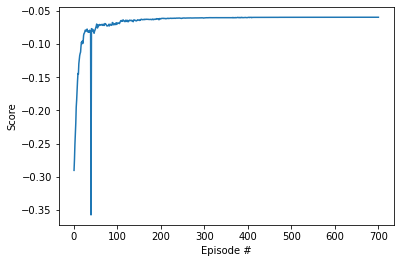

In [5]:
#Execute the cross entrophy method with default Values
#scores = cem()


#To don't ask the GPU as much reduce the pop_size, it's the amount of elemts try
scores,best_actions = cem_no_net()
# 
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
    

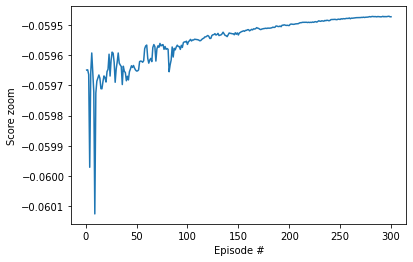

In [6]:

# plot the last scores zoom
fig = plt.figure()
zoom= 300
ax = fig.add_subplot(111)
plt.plot(np.arange(1, zoom+1), scores[-zoom:])
plt.ylabel('Score zoom')
plt.xlabel('Episode #')
plt.show()

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


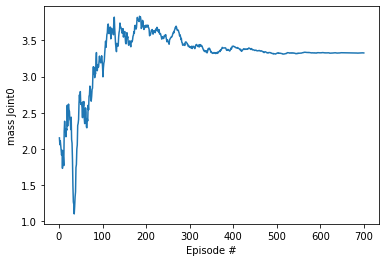

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


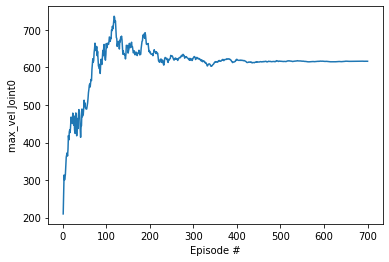

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


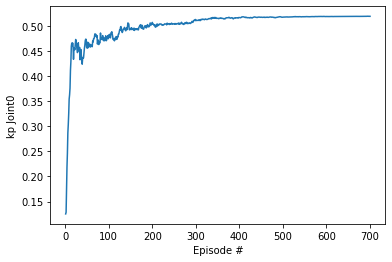

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


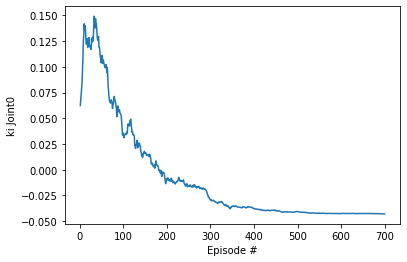

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


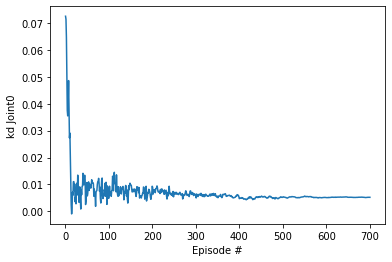

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


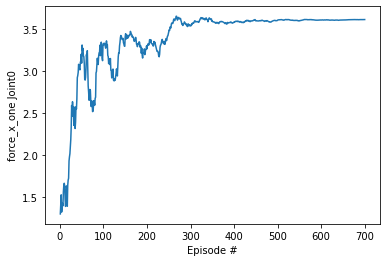

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


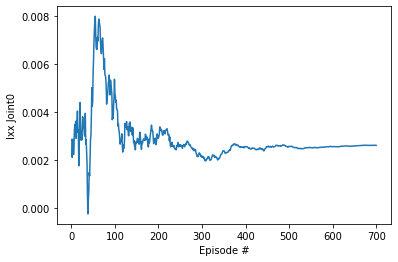

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


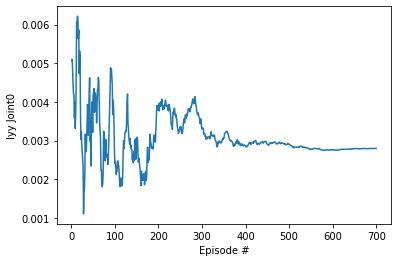

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


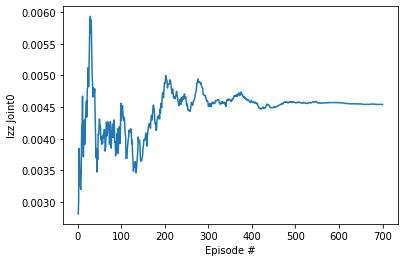

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


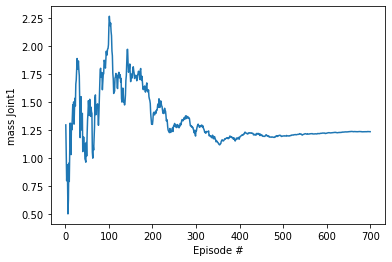

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


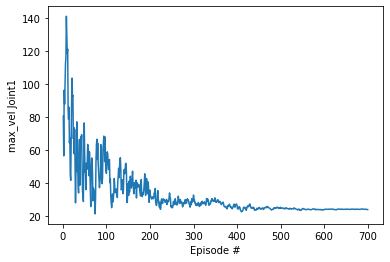

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


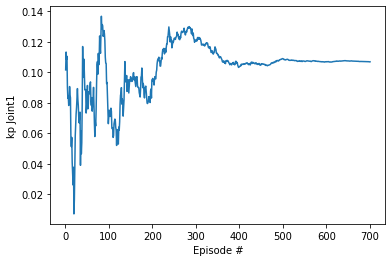

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


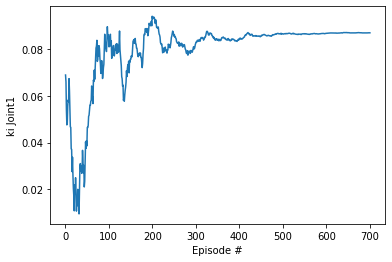

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


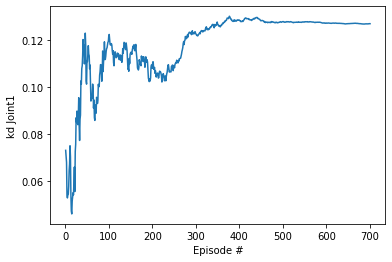

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


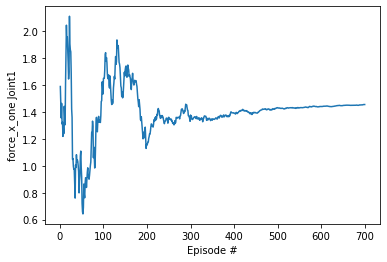

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


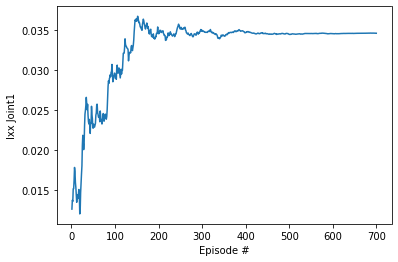

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


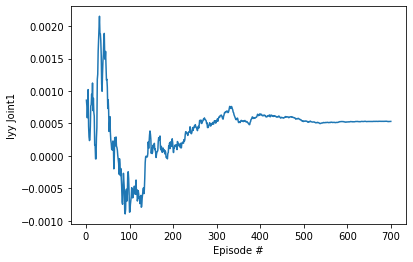

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


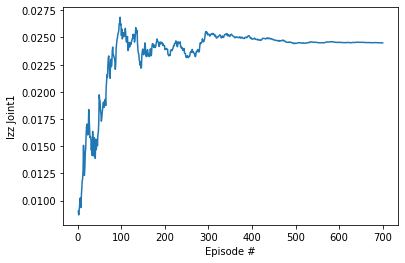

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


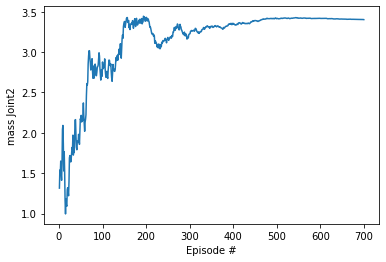

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


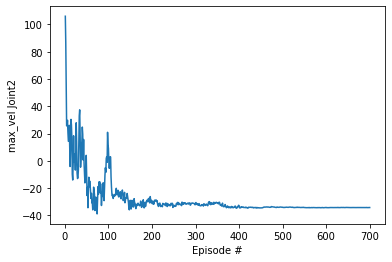

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


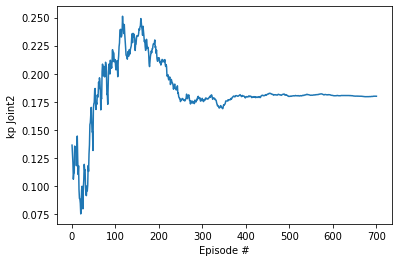

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


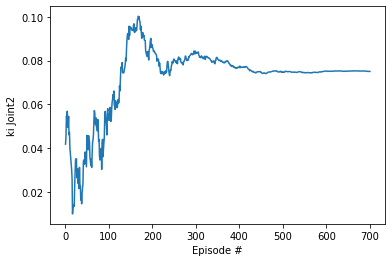

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


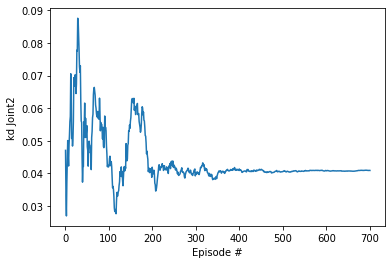

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


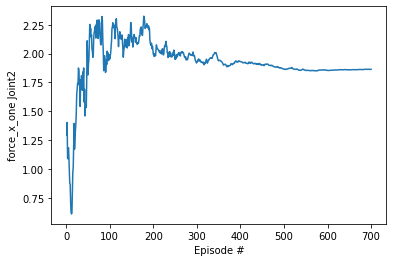

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


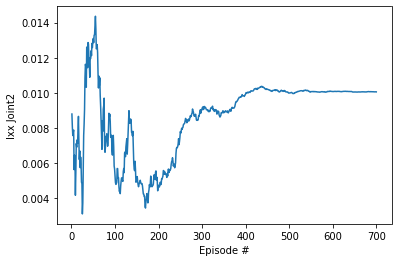

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


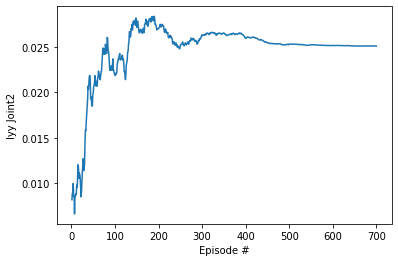

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


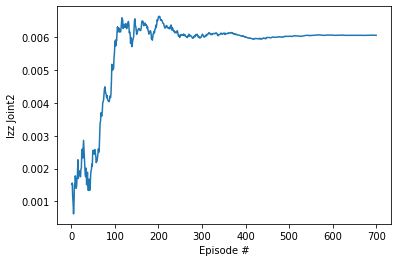

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


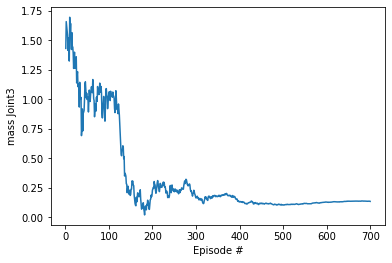

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


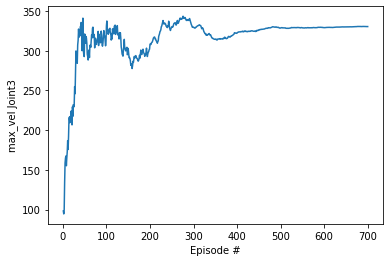

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


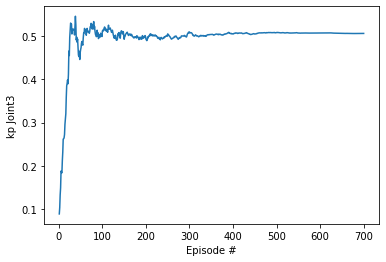

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


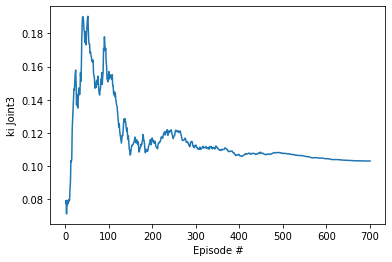

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


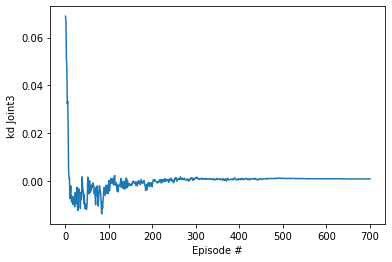

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


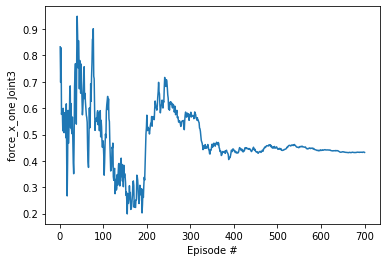

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


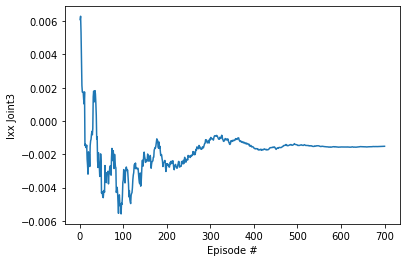

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


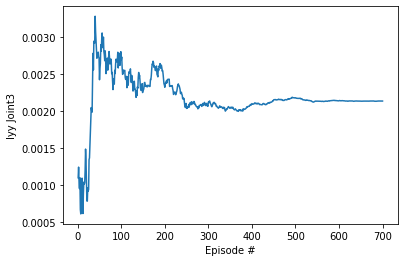

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


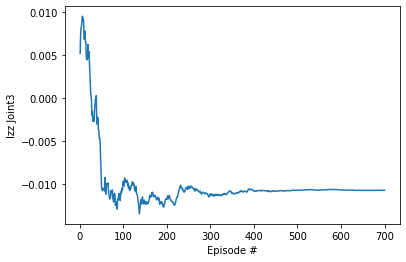

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


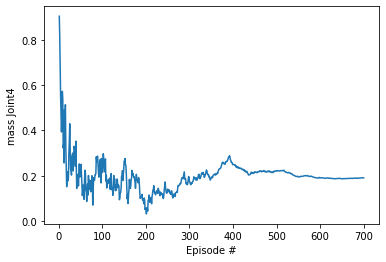

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


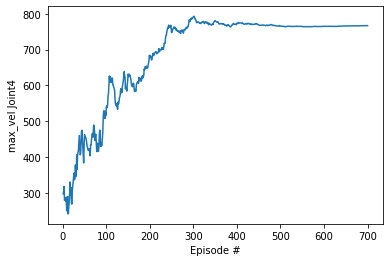

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


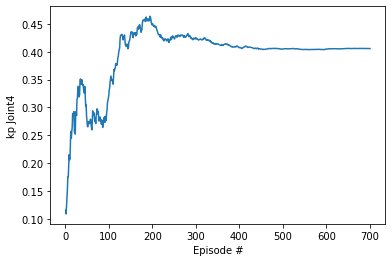

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


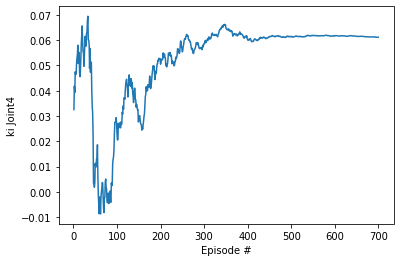

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


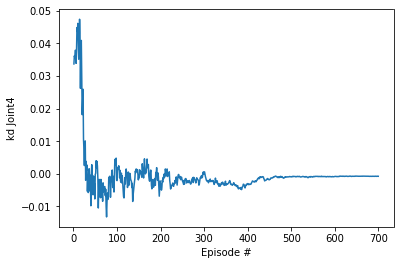

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


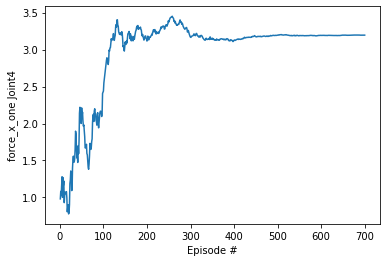

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


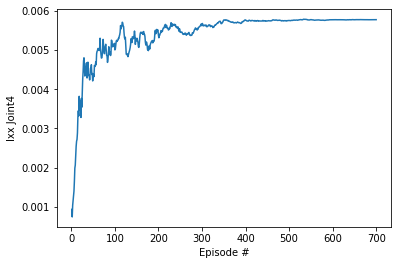

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


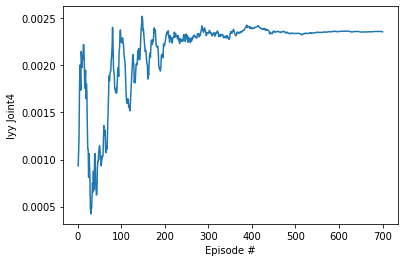

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


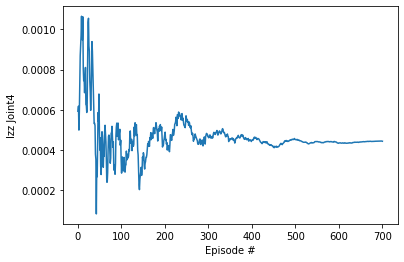

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


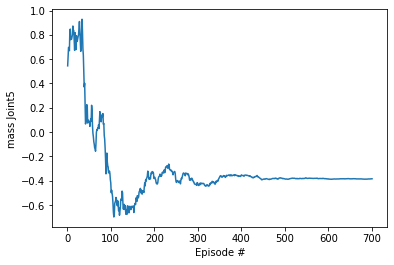

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


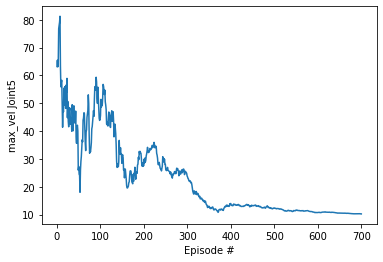

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


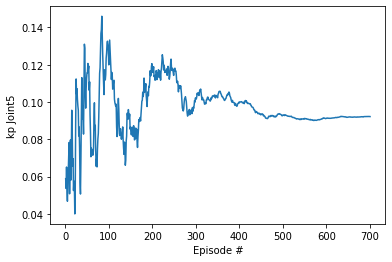

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


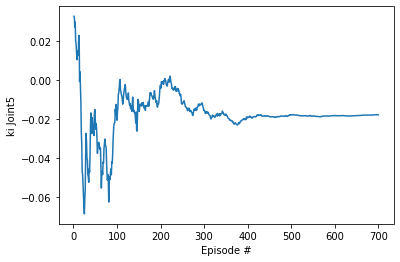

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


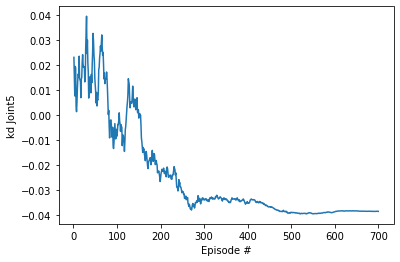

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


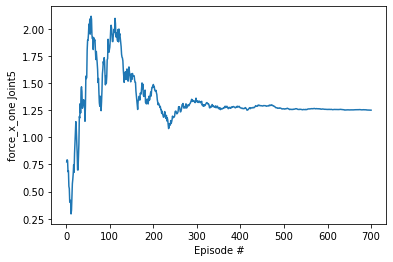

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


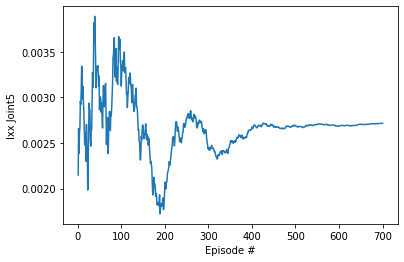

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


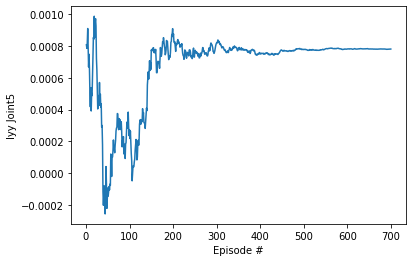

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


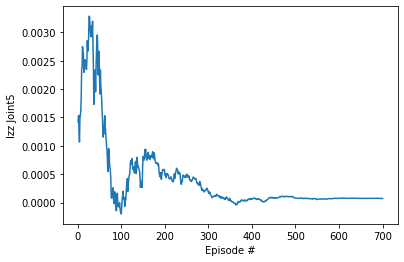

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


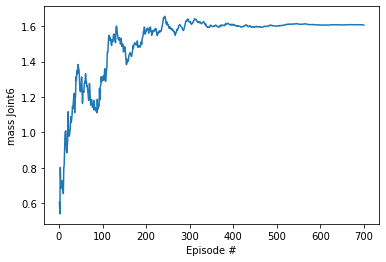

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


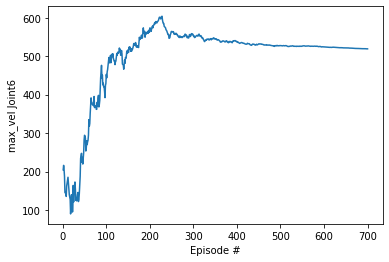

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


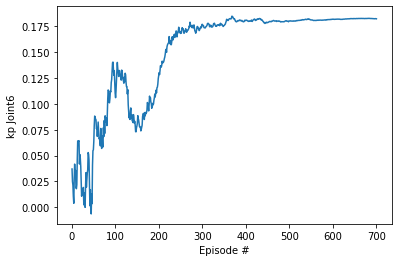

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


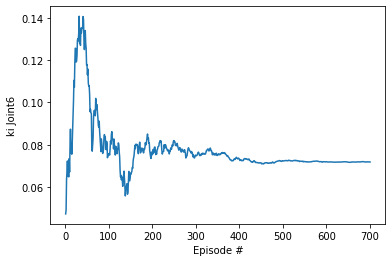

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


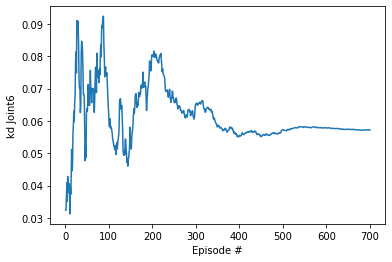

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


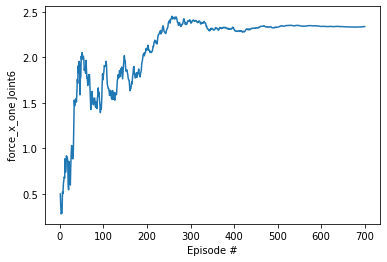

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


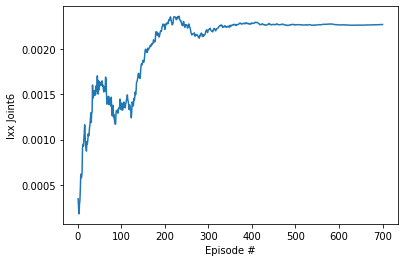

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


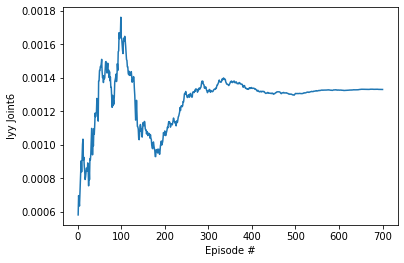

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


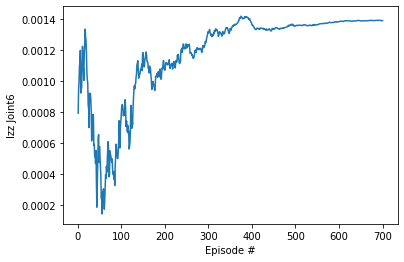

In [7]:
# plot actions
best_actions_np = np.array(best_actions)
for joint in range(7):
    for i in range(len(env.parameters_to_modify)) :
        parameter = env.parameters_to_modify[i]
        figures = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(1, best_actions_np.shape[0]+1), best_actions_np[:,joint+i*7])
        plt.ylabel(parameter+" Joint"+str(joint))
        plt.xlabel('Episode #')
        plt.show()

In [3]:
# load the weights from file
# Not working know


#state = env.reset()
env = env_pybullet_kin_gen3(no_zeros = True,Excels_path_Okay_tcp_list = ["Tcp_Trajectori_19_2.xlsx","Tcp_Trajectori_39_2.xlsx","Tcp_Trajectori_59_2.xlsx"],\
                            Actions_offsets_Numpy_files = ["acs_19_tcp.npy","acs_39_tcp.npy","acs_59_tcp.npy"],time_step=0.02,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
env.robot.visual_inspection = True

#Make maxvels closer to the reality
env.max_vel = [168,151,128,94,210,48,189]
env.original_parameters_df ["max_vel"]=env.max_vel
env.modified_parameters_df ["max_vel"]=[168,151,128,94,210,48,189]

env.update_parameters_to_modify(["mass","max_vel","kp","ki","kd","force_x_one","Ixx","Iyy","Izz","damping"])
env.robot.visual_inspection = True
env.modified_parameters_df = env.create_df_from_Excel("./Parameters_train_tcp_euc_rishabh_joint_offset.xlsx")


t.sleep(0.02)
action = env.action_modified()
action = np.array(action)
print('original action:', env.action_original()) #parameters, number of parameters choose to tune, continuous
print("trained",action)
reward = env.step_tcp_rishabh_joints_offset(action)
print("reward")
print(reward)



hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
Base parameters mod    mass_base  Ixx_base  Iyy_base  Izz_base
0   1.697353  0.005787  0.005796  0.002735
Base parameters     mass_base  Ixx_base  Iyy_base  Izz_base
0   1.697353  0.005787  0.005796  0.002735
mass okey
max_vel okey
kp okey
ki okey
kd okey
force_x_one okey
Ixx okey
Iyy okey
Izz okey
damping okey
actions without base 7
actions without base 14
actions without base 21
actions without base 28
actions without base 35
actions without base 42
actions without base 49
actions without base 56
actions without base 63
actions without base 70
original action: [1.377353, 1.163667, 1.16366, 0.930287, 0.678106, 0.678106, 0.500657, 168, 151, 128, 94, 210, 48, 189, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 1, 1, 1, 1, 1, 1, 1, 0.00480078220558528, 0.008418724123621643, 0.007544516197001279, 0.0064096919604697605, 0.00

In [4]:
#Convert to excel
a = env.df_avg.to_numpy()
print(a[:,5])
env.df_avg.to_excel("./Train_parameters_result_tcp_euc_rishabh_joint_offset.xlsx")

[-0.0095213  -0.13636163 -0.18730817 -0.23748297 -0.34320593 -0.44606546
 -0.47578707 -0.53430777 -0.58481331 -0.37468285 -0.1728819  -0.1990195
  0.01225406  0.17781437  0.28425549  0.25451044  0.11623531  0.02208678
  0.025815   -0.00559265  0.05222233  0.01304057 -0.03596268  0.00863289
  0.08169782  0.19024396  0.10548728  0.24573374  0.149165    0.12240368
  0.17950182  0.31984078  0.34944873  0.33946725  0.33565768  0.42768946
  0.47761711  0.52140175  0.44031624  0.36627844  0.38060153  0.41018121
  0.31080005  0.28722182  0.36347039  0.42036513  0.41643083  0.36789871
  0.33548508  0.3890583   0.56717977  0.73487343  0.60864424  0.58612671
  0.62738948  0.63997432  0.61445437  0.65817312  0.59347833  0.60274421
  0.65558892  0.65672962  0.61555911  0.55302915  0.57375878  0.63359609
  0.64299164  0.59859217  0.63464731  0.60157962  0.57055173  0.63517402
  0.51267517  0.55606261  0.66587127  0.65430328  0.48600033  0.48335949
  0.56273828  0.58350038  0.5790281   0.61542374  0.

In [ ]:
env.original_parameters_df

In [ ]:
#Original ERROR
# load the weights from file
# Not working know


#state = env.reset()
env = env_pybullet_kin_gen3(no_zeros = True,Excels_path_Okay_tcp_list = ["Tcp_Trajectori_19_2.xlsx","Tcp_Trajectori_39_2.xlsx","Tcp_Trajectori_59_2.xlsx"],\
                            Actions_offsets_Numpy_files = ["acs_19_tcp.npy","acs_39_tcp.npy","acs_59_tcp.npy"],time_step=0.02,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
#Make maxvels closer to the reality
env.max_vel = [168,151,128,94,210,48,189]
env.original_parameters_df ["max_vel"]=env.max_vel
env.modified_parameters_df ["max_vel"]=[168,151,128,94,210,48,189]

env.update_parameters_to_modify(["mass","max_vel","kp","ki","kd","force_x_one","Ixx","Iyy","Izz"])
env.update_parameters_to_modify_base(["mass_base"])
env.robot.visual_inspection = True
env.modified_parameters_df = env.original_parameters_df


t.sleep(10)
action = env.action_modified()

action = np.array(action)
print(action)
reward = env.step_tcp_rishabh_joints_offset(action)

print("reward")
print(reward)

In [ ]:
#Convert to excel
a = env.df_avg.to_numpy()
print(a[:,5])
env.df_avg.to_excel("./Original_parameters_result_tcp_euc_rishabh_joint_offset_59.xlsx")